$$ \text{\Huge{Asteroid}} $$

**Dataset:** [Kaggle](https://www.kaggle.com/datasets/sameepvani/nasa-nearest-earth-objects?resource=download)

$$ \text{\Huge{Setup}} $$

In [1]:
from __future__ import annotations

import matplotlib.pyplot as plt
import numpy as np
import numpy.typing as npt
import pandas as pd
import plotly.express as px
import scienceplots
import seaborn as sns
import shap
import sklearn as sk
import tensorflow as tf

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from imblearn.under_sampling import RandomUnderSampler
from IPython.display import display, HTML
from keras_tuner.tuners import Hyperband
from keras_tuner.engine.hyperparameters import HyperParameters
from pathlib import Path
from random import sample
from sklearn.inspection import permutation_importance
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    f1_score,
    mean_absolute_error,
    mean_squared_error,
    precision_score,
    r2_score,
    recall_score
)
from sklearn.model_selection import (
    cross_val_score,
    GridSearchCV,
    RepeatedStratifiedKFold,
    train_test_split
)
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from subprocess import Popen
from tensorflow import keras
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

In [2]:
plt.style.use('science')

plt.rcParams['axes.titlesize'] = 24
plt.rcParams['axes.labelsize'] = 20
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14
plt.rcParams['axes.titlepad'] = 15 
plt.rcParams['axes.labelpad'] = 15
plt.rcParams['legend.title_fontsize'] = 16
plt.rcParams['legend.fontsize'] = 12

In [3]:
path = Path('images')
path.mkdir(exist_ok=True)

In [4]:
CASES = {
    'est': 'Estimated',
    'max': 'Maximum',
    'min': 'Minimum',
    'param': ''
}

def column_to_title(column: str) -> str:
    column = column.replace('_', ' ').title()

    for word, replacement in CASES.items():
        column = column.replace(word.title(), replacement)

    return column

In [5]:
def update_label(labels: list[str]) -> list[str]:
    y = []
    
    for label in labels:
        text = label.get_text()
        label = column_to_title(text)
        
        y.append(label)

    return y

In [6]:
def display_correlation(dataset: pd.DataFrame) -> None:
    figsize = (12, 12)
    fig, ax = plt.subplots(figsize=figsize)

    correlation = dataset.corr()

    heatmap = sns.heatmap(
        correlation,
        annot=True,
        annot_kws={'size': 16},
        cmap='Blues',
        fmt='.2f',
        square=True
    )

    x = [x.get_text() for x in ax.get_xticklabels()]
    y = [y.get_text() for y in ax.get_yticklabels()]

    x = map(column_to_title, x)
    y = map(column_to_title, y)

    ax.tick_params(axis='both', which='both', length=0)

    ax.set_xticklabels(x, rotation=45, ha='right')
    ax.set_yticklabels(y, rotation=45, va='center')

    plt.tight_layout()
    plt.show()
    plt.close()

In [7]:
def display_confusion_matrix(
    test: npt.NDArray, 
    prediction: npt.NDArray
):
    figsize = (8, 8)
    fig, ax = plt.subplots(figsize=figsize)

    cm = confusion_matrix(test, prediction)

    heatmap = sns.heatmap(
        cm, 
        annot=True,
        annot_kws={'size': 16},
        square=True, 
        fmt='.0f'
    )
    
    plt.xlabel('Predicted label')
    plt.ylabel('True label')

    ax.tick_params(axis='both', which='both', length=0)

    cbar = heatmap.collections[0].colorbar
    cbar.ax.tick_params(length=0)  

    plt.show()
    plt.close()

In [8]:
def display_permutation_importance(data: pd.DataFrame, name: str | None = None) -> None:
    figsize = (18, 9)
    fig, ax = plt.subplots(figsize=figsize)
    
    sns.barplot(
        data=data,
        y='variable',
        x='importance',
        hue='variable',
        palette='hls',
        legend=False
    )
    
    ax.tick_params(axis='y', which='both', left=False, right=False)
    
    ax.set_xlabel('Importance')
    ax.set_ylabel('Variable')
    
    yticks = ax.get_yticks()
    yticklabels = ax.get_yticklabels()
    yticklabels = update_label(yticklabels)
    
    ax.set_yticks(yticks)
    ax.set_yticklabels(yticklabels)

    title = f"Permutation Importance for {name}"
    ax.set_title(title)
    
    plt.tight_layout()
    plt.show()
    plt.close()

In [9]:
def display_classification_score( 
    test: npt.NDArray, 
    prediction: npt.NDArray,
    **kwargs
) -> pd.DataFrame:        
    score = {}

    accuracy = accuracy_score(
        test,
        prediction
    )

    precision = precision_score(
        test,
        prediction,
        **kwargs
    )

    recall = recall_score(
        test,
        prediction,
        **kwargs
    )

    f1 = f1_score(
        test,
        prediction,
        **kwargs
    )

    score['Accuracy'] = accuracy
    score['Precision'] = precision
    score['Recall'] = recall
    score['F1'] = f1

    data = score.items()
    columns = ['Metric', 'Score']

    return pd.DataFrame(data=data, columns=columns)


def display_deep_score(loss: float, accuracy: float) -> pd.DataFrame:        
        score = {}

        score['Loss'] = loss
        score['Accuracy'] = accuracy

        data = score.items()
        columns = ['Metric', 'Score']

        return pd.DataFrame(data=data, columns=columns)

$$ \text{\Huge{Data exploration and visualization}} $$

In [10]:
dtype = {
    'absolute_magnitude': 'float64',
    'est_diameter_max': 'float64',
    'est_diameter_min': 'float64',
    'hazardous': 'bool',
    'miss_distance': 'float32',
    'relative_velocity': 'float64'
}

usecols = [
    'absolute_magnitude',
    'est_diameter_max',
    'est_diameter_min',
    'hazardous',
    'miss_distance',
    'relative_velocity',
]

data = Path('dataset/neo.csv')

df_asteroid = pd.read_csv(
    data,
    engine='python',
    dtype=dtype,
    usecols=usecols
)

In [11]:
df_asteroid.shape

(90836, 6)

In [12]:
df_asteroid.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90836 entries, 0 to 90835
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   est_diameter_min    90836 non-null  float64
 1   est_diameter_max    90836 non-null  float64
 2   relative_velocity   90836 non-null  float64
 3   miss_distance       90836 non-null  float32
 4   absolute_magnitude  90836 non-null  float64
 5   hazardous           90836 non-null  bool   
dtypes: bool(1), float32(1), float64(4)
memory usage: 3.2 MB


In [13]:
df_asteroid.head(5)

,est_diameter_min,est_diameter_max,relative_velocity,miss_distance,absolute_magnitude,hazardous
0,1.198271,2.679415,13569.249224,54839744.0,16.73,False
1,0.265800,0.594347,73588.726663,61438128.0,20.00,True
2,0.722030,1.614507,114258.692129,49798724.0,17.83,False
3,0.096506,0.215794,24764.303138,25434972.0,22.20,False
4,0.255009,0.570217,42737.733765,46275568.0,20.09,True


In [14]:
df_asteroid.isna().sum()

est_diameter_min      0
est_diameter_max      0
relative_velocity     0
miss_distance         0
absolute_magnitude    0
hazardous             0
dtype: int64

In [15]:
df_asteroid.describe()

,est_diameter_min,est_diameter_max,relative_velocity,miss_distance,absolute_magnitude
count,90836.000000,90836.000000,90836.000000,9.083600e+04,90836.000000
mean,0.127432,0.284947,48066.918918,3.706655e+07,23.527103
std,0.298511,0.667491,25293.296961,2.235204e+07,2.894086
min,0.000609,0.001362,203.346433,6.745533e+03,9.230000
25%,0.019256,0.043057,28619.020645,1.721082e+07,21.340000
50%,0.048368,0.108153,44190.117890,3.784658e+07,23.700000
75%,0.143402,0.320656,62923.604633,5.654900e+07,25.700000
max,37.892650,84.730541,236990.128088,7.479865e+07,33.200000


- *Miss Distance* has the highest maximum value while *Absolute Magnitude* has the lowest maximum value.
- *Miss Distance* has the highest mean value while *Estimated Diameter Minimum* has the lowest mean value.

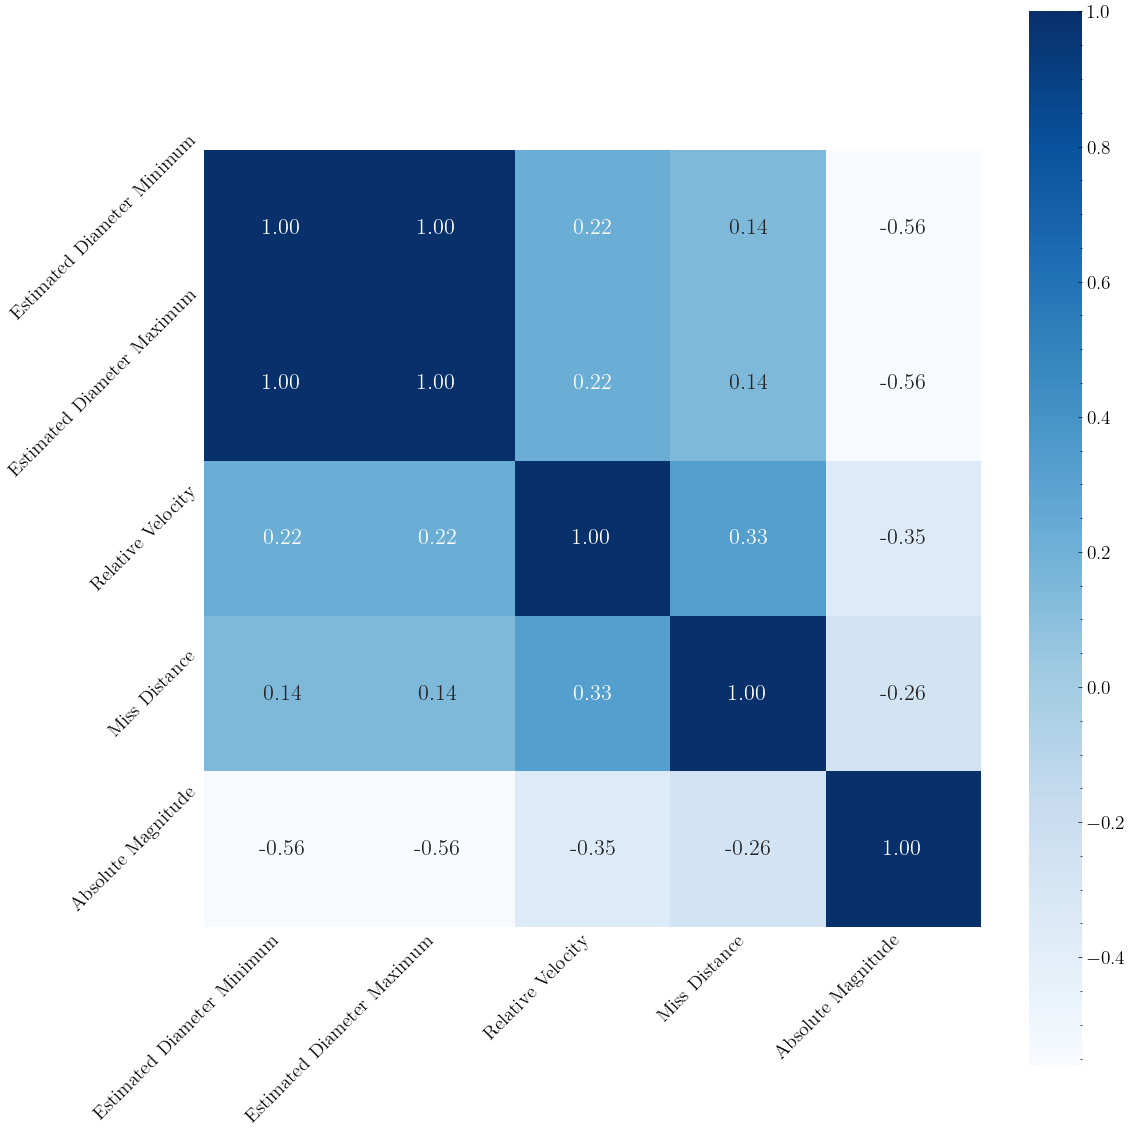

In [16]:
numerical = df_asteroid.select_dtypes(include='number')
display_correlation(numerical)

- *Estimated Diameter Maximum* and *Estimated Diameter Maximum* have a perfect positive correlation, because they have a magnitude of 1.00.
- *Absolute Magnitude* and *Estimated Diameter Maximum* have a negative correlation, because they have a magnitude of -0.56.

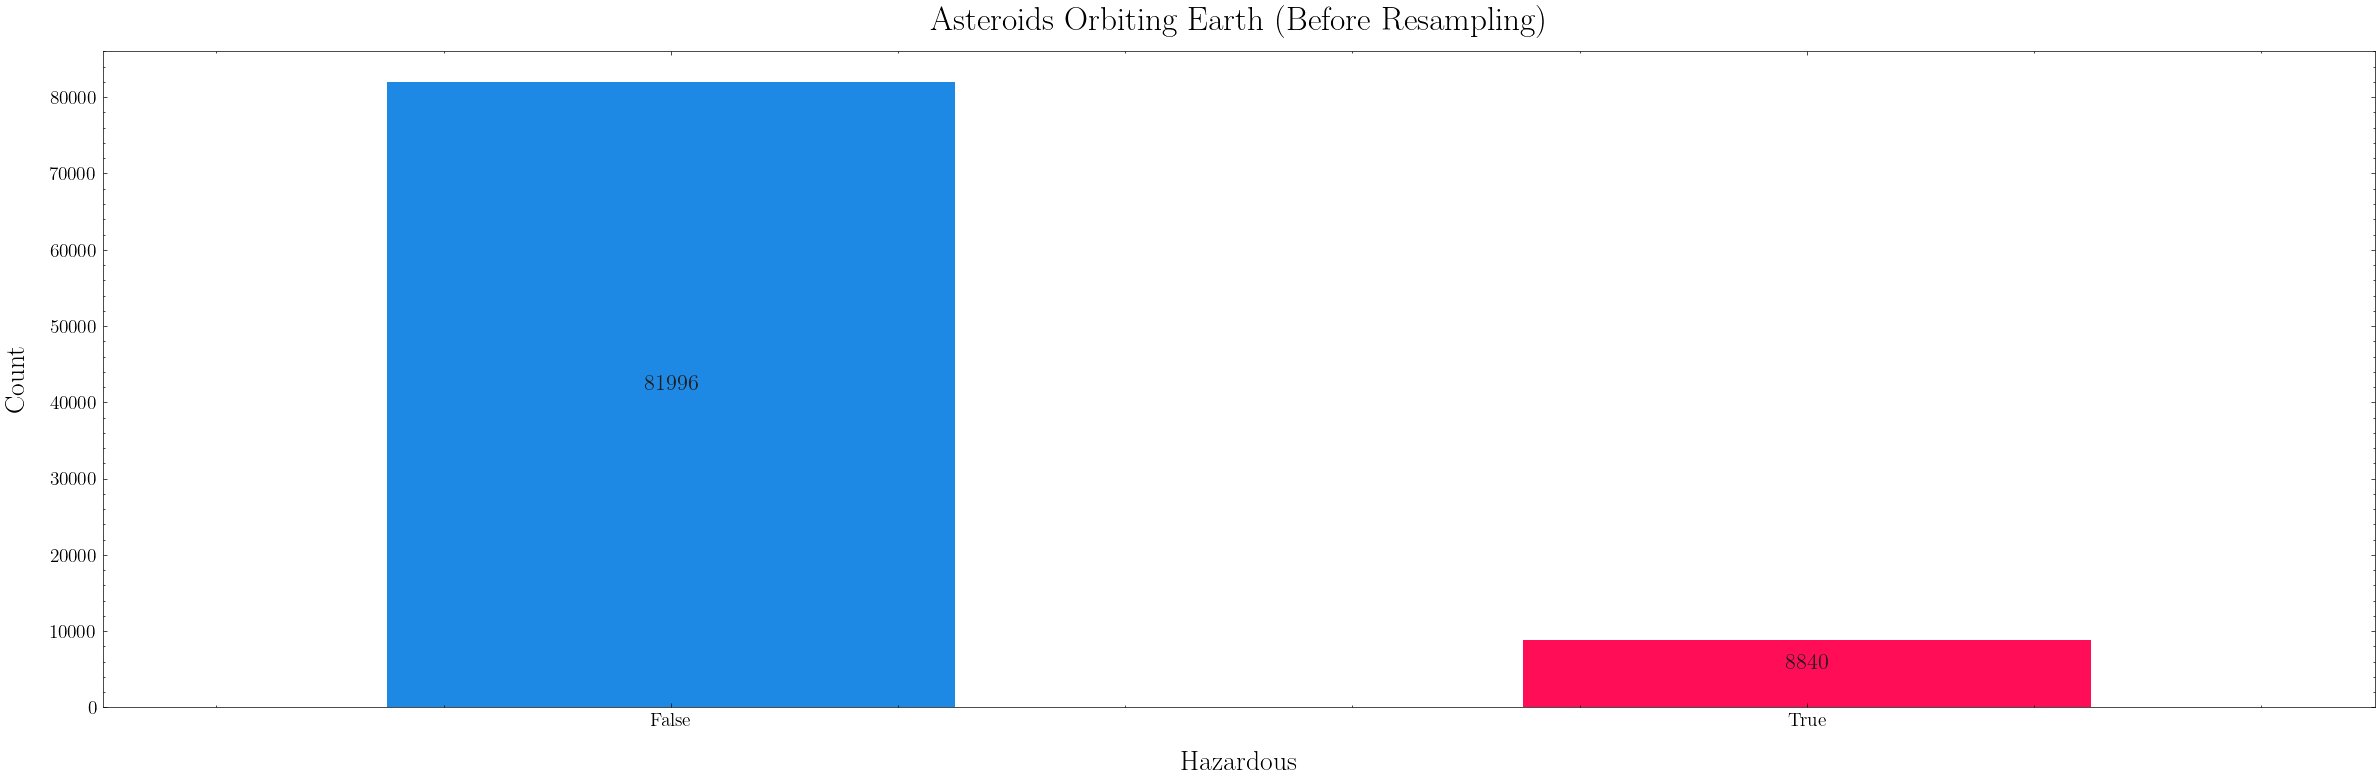

In [17]:
figsize = (24, 8)
fig, ax = plt.subplots(figsize=figsize)

color = ['#1e88e5', '#ff0d57']

df_asteroid.hazardous.value_counts().plot(kind='bar', color=color)
labels = df_asteroid.hazardous.value_counts().tolist()

for rectangle, label in zip(ax.patches, labels):
    ax.text(
        rectangle.get_x() + rectangle.get_width() / 2,
        rectangle.get_y() + rectangle.get_height() / 2,
        label,
        color='#1e1e1e',
        size=16,
        ha='center',
        va='bottom',
    )

ax.set_xlabel('Hazardous')
ax.set_ylabel('Count')

plt.xticks(rotation=0)

ax.set_title('Asteroids Orbiting Earth (Before Resampling)')

plt.tight_layout()
plt.show()
plt.close()

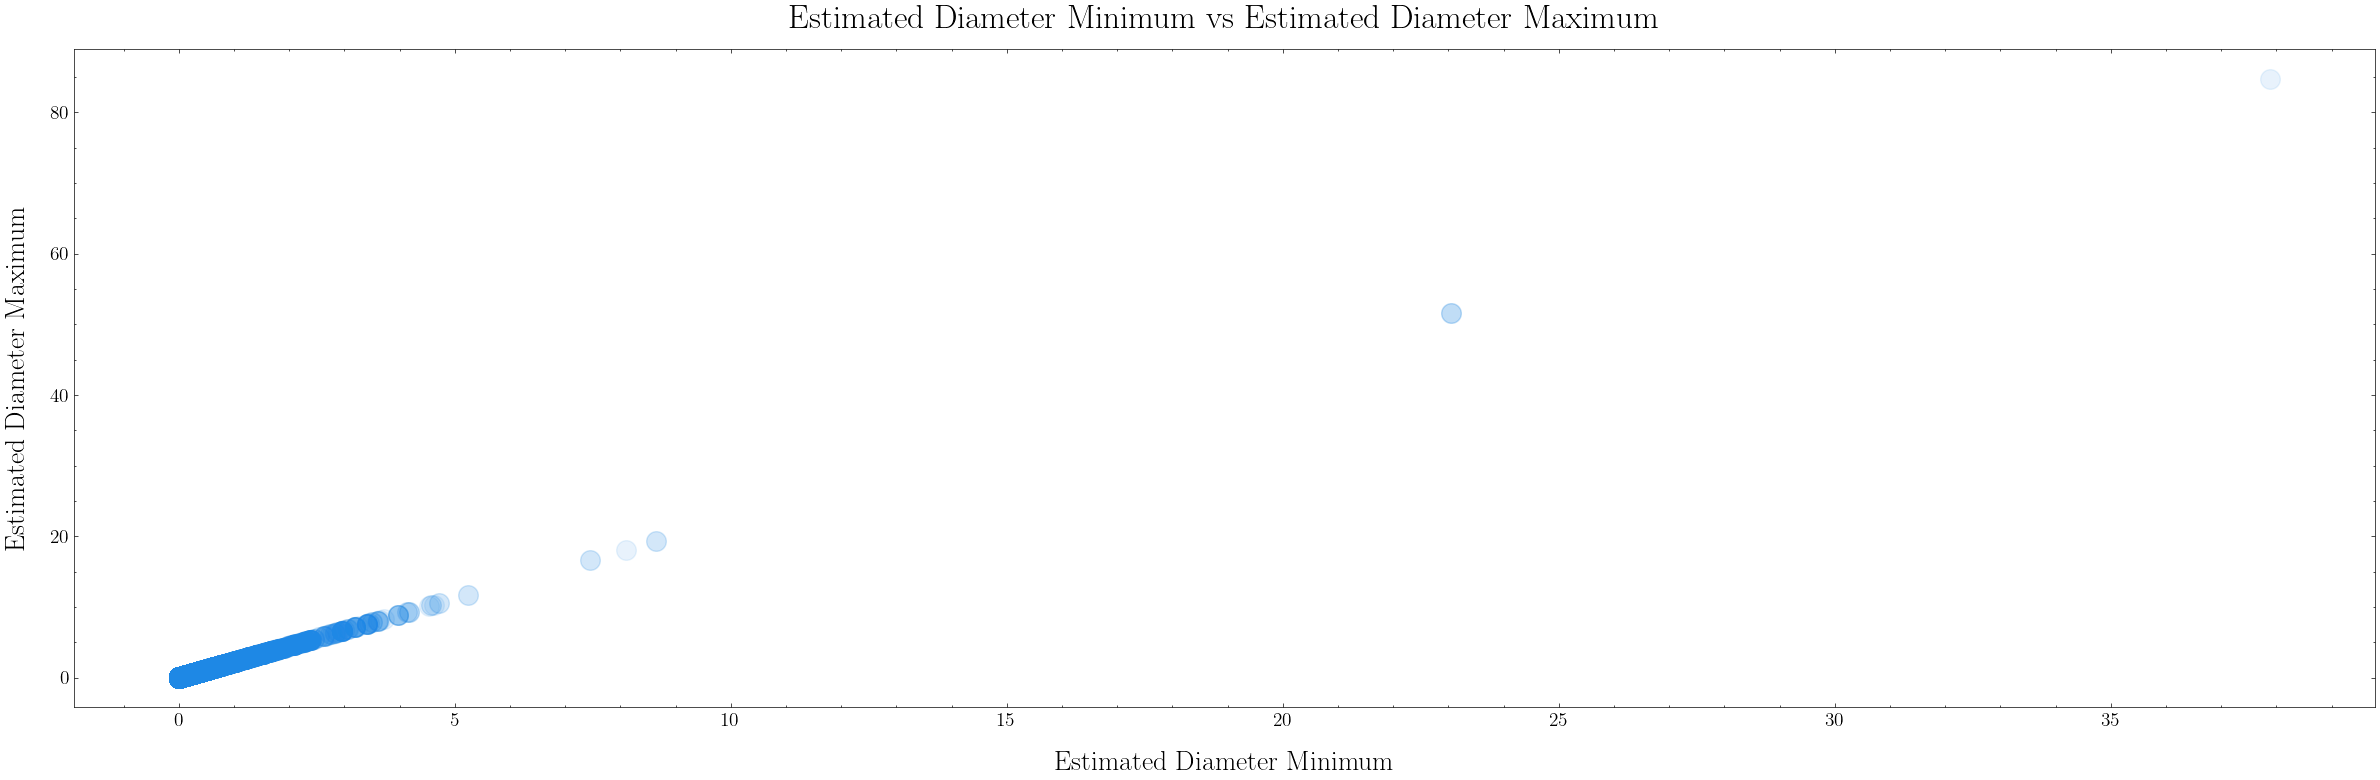

In [18]:
figsize = (24, 8)
fig, ax = plt.subplots(figsize=figsize)

x = 'est_diameter_min'
y = 'est_diameter_max'

ax.scatter(
    x=df_asteroid[x],
    y=df_asteroid[y],
    color='#1e88e5',
    s=200,
    alpha=0.10
)

x = column_to_title(x)
y = column_to_title(y)

ax.set_xlabel(x)
ax.set_ylabel(y)

ax.set_title(f"{x} vs {y}")

plt.tight_layout()
plt.show()
plt.close()

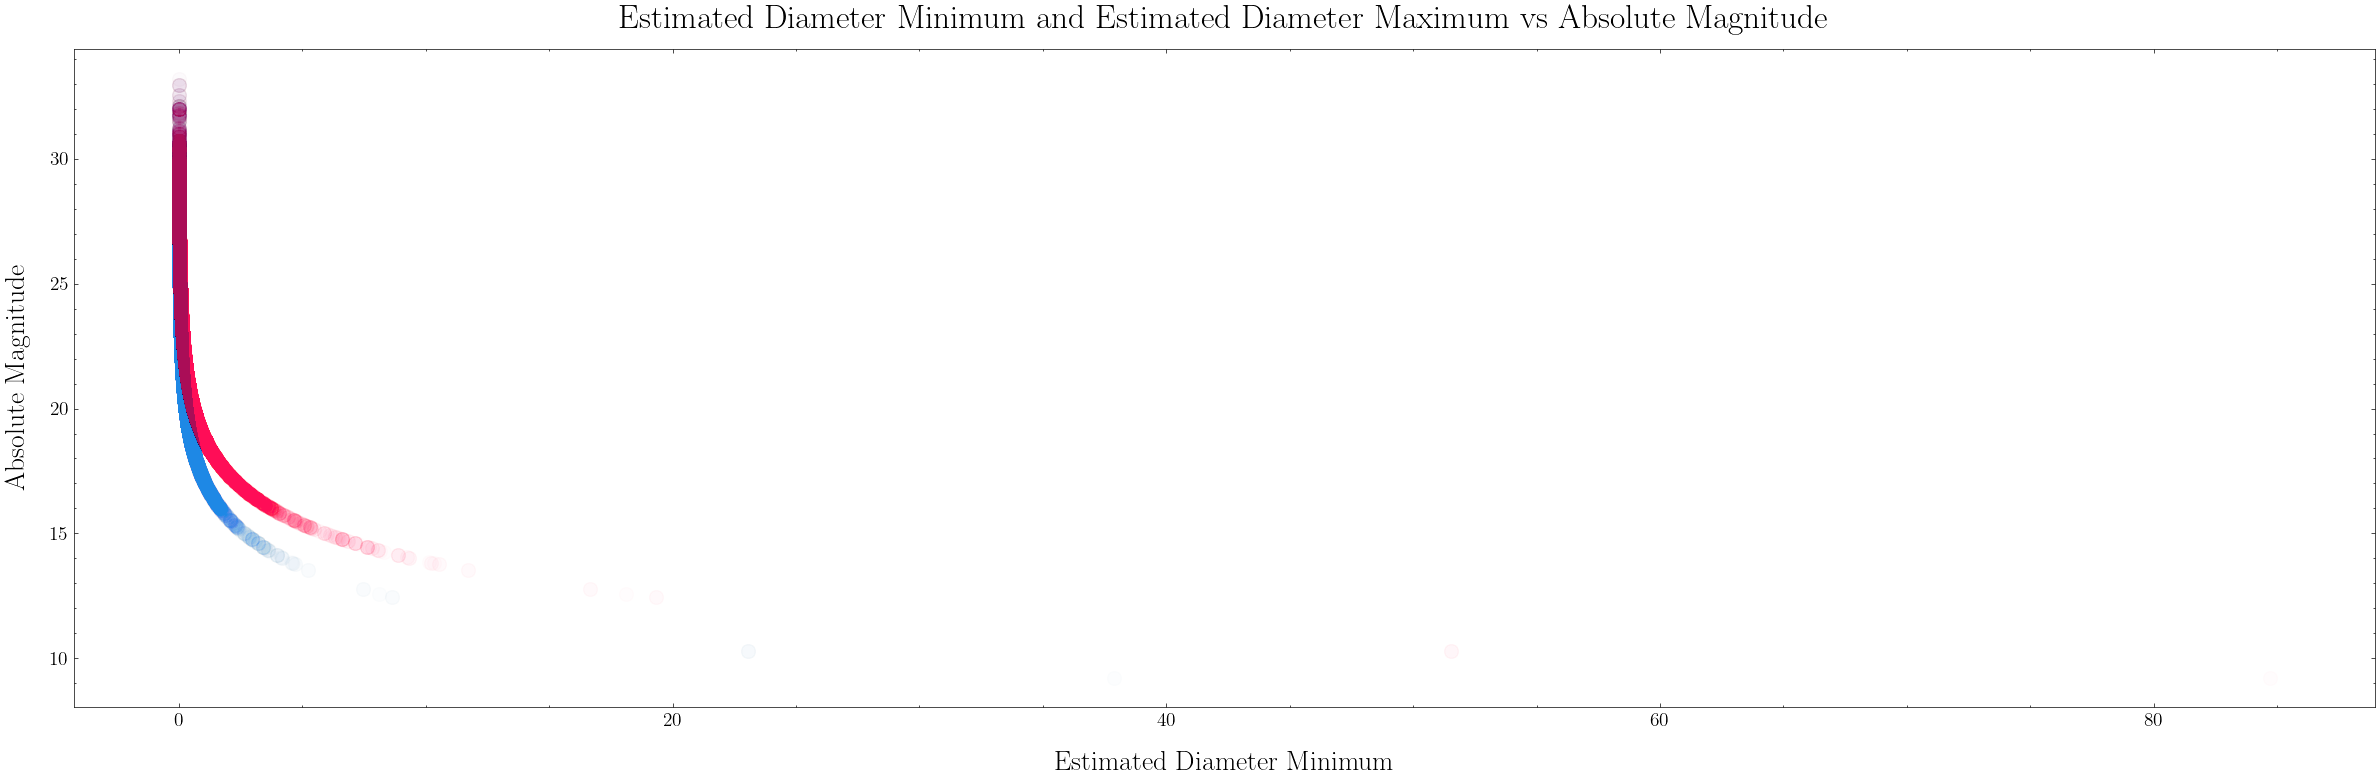

In [19]:
figsize = (24, 8)
fig, ax = plt.subplots(figsize=figsize)

x1 = 'est_diameter_min'
x2 = 'est_diameter_max'
y = 'absolute_magnitude'

ax.scatter(
    x=df_asteroid[x1],
    y=df_asteroid[y],
    color='#1e88e5',
    s=100,
    alpha=0.01
)

ax.scatter(
    x=df_asteroid[x2],
    y=df_asteroid[y],
    color='#ff0d57',
    s=100,
    alpha=0.01
)

x1 = column_to_title(x1)
x2 = column_to_title(x2)
y = column_to_title(y)

ax.set_xlabel(x)
ax.set_ylabel(y)

ax.set_title(f"{x1} and {x2} vs {y}")

plt.tight_layout()
plt.show()
plt.close()

$$\text{\Huge{Data preprocessing}}$$

In [20]:
oe = ['hazardous']

encoder = OrdinalEncoder()

df_asteroid[oe] = encoder.fit_transform(
    df_asteroid[oe]
)

In [21]:
target = 'hazardous'

X = df_asteroid.drop(target, axis=1)
y = df_asteroid[target]

We attempted to resample our dataset, because there was a severe imbalance in our target variable, which would skew the model's ability to accurately predict if an asteroid was hazardous or not.

In [22]:
def get_best_score(k_neighbors, oss, uss):
    k = 0
    score = 0

    for k_neighbor in k_neighbors:
        model = LogisticRegression()

        oversampling = SMOTE(
            n_jobs=-1,
            sampling_strategy=oss,
            k_neighbors=k_neighbor
        )

        undersampling = RandomUnderSampler(sampling_strategy=uss)

        steps = [
            ('over', oversampling),
            ('under', undersampling),
            ('model', model)
        ]

        pipeline = Pipeline(steps=steps)

        cv = RepeatedStratifiedKFold(
            n_repeats=3,
            n_splits=10,
            random_state=1
        )

        scores = cross_val_score(
            pipeline,
            X,
            y,
            scoring='roc_auc',
            cv=cv,
            n_jobs=-1
        )

        mean = np.mean(scores)

        if mean > score:
            score = mean
            k = k_neighbor

    return (k, score)

In [23]:
k_neighbors = [i for i in range(1, 10)]
score = get_best_score(k_neighbors, 0.6, 0.9)

print(f"Score: {score}")

Score: (9, 0.7050559542975913)


In [24]:
oversampling = SMOTE(
    k_neighbors=2,
    sampling_strategy=0.6
)

undersampling = RandomUnderSampler(
    sampling_strategy=0.9
)

steps = [
    ('oversampling', oversampling),
    ('undersampling', undersampling)
]

pipeline = Pipeline(steps=steps)

In [25]:
X_rs, y_rs = pipeline.fit_resample(X, y)

In [26]:
X_train_all, X_test, y_train_all, y_test = train_test_split(X_rs, y_rs, test_size=0.20)
X_train, X_val, y_train, y_val = train_test_split(X_train_all, y_train_all, test_size=0.20)

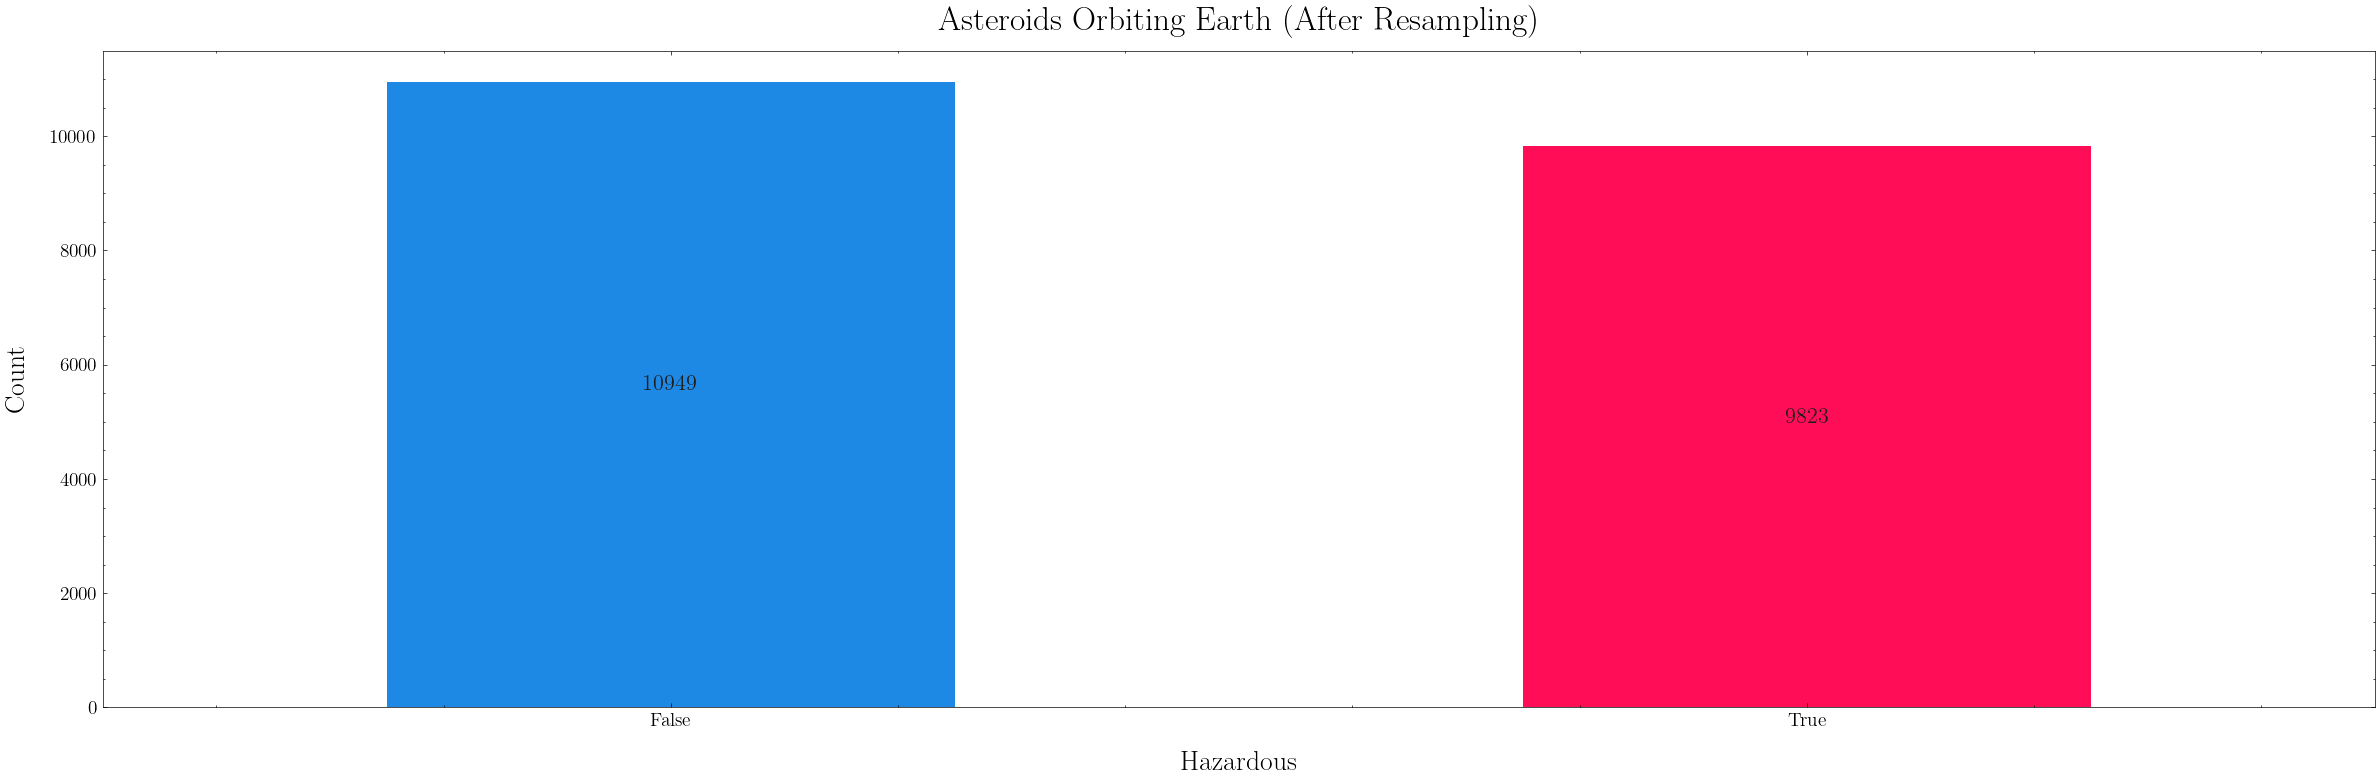

In [27]:
figsize = (24, 8)
fig, ax = plt.subplots(figsize=figsize)

color = ['#1e88e5', '#ff0d57']

y_test.value_counts().plot(kind='bar', color=color)
labels = y_test.value_counts().tolist()

for rectangle, label in zip(ax.patches, labels):
    ax.text(
        rectangle.get_x() + rectangle.get_width() / 2,
        rectangle.get_y() + rectangle.get_height() / 2,
        label,
        color='#1e1e1e',
        size=16,
        ha='center',
        va='bottom',
    )

ax.set_xticklabels(['False', 'True'])

plt.xticks(rotation=0)

ax.set_xlabel('Hazardous')
ax.set_ylabel('Count')

ax.set_title('Asteroids Orbiting Earth (After Resampling)')

plt.tight_layout()
plt.show()
plt.close()

In [28]:
scale = (
    df_asteroid
    .drop('hazardous', axis=1)
    .select_dtypes(include='number')
    .columns
)

scaler = StandardScaler()

X_train[scale] = scaler.fit_transform(X_train[scale])
X_val[scale] = scaler.transform(X_val[scale])
X_test[scale] = scaler.transform(X_test[scale])

$$ \text{\Huge{Shallow Learning (Logistic Regression)}} $$

$$ \text{\LARGE{Model building}} $$

In [29]:
%%capture

C = [0.001, 0.01, 0.1, 1, 10, 100, 1000]
max_iter = [i for i in range(100, 1000, 100)]
# penalty = ['elasticnet', 'l1', 'l2', 'none']
# solver = ['saga']

param_grid = {
    'C': C,
    'max_iter': max_iter,
    # 'penalty': penalty,
    # 'solver': solver
}

search_shallow = GridSearchCV(
    LogisticRegression(),
    param_grid=param_grid,
    cv=10,
    scoring='accuracy',
    return_train_score=True,
    n_jobs=-1,
    verbose=1
)

search_shallow.fit(X_train, y_train)

In [30]:
df_score_shallow = pd.DataFrame(search_shallow.cv_results_)

for k, v in search_shallow.best_params_.items():
    print(f"{k}: {v}")

C: 0.001
max_iter: 100


In [31]:
%%capture

C = search_shallow.best_params_.get('C')
max_iter = search_shallow.best_params_.get('max_iter')
# penalty = search_shallow.best_params_.get('penalty')
# solver = search_shallow.best_params_.get('solver')

model_shallow = LogisticRegression(
    C=C,
    max_iter=max_iter,
    # penalty=penalty,
    # solver=solver
)

model_shallow.fit(X_train, y_train)

In [32]:
y_pred_test_shallow = model_shallow.predict(X_test)

In [33]:
y_pred_train_shallow = model_shallow.predict(X_train)

$$ \text{\LARGE{Model testing}} $$

$$ \text{\Large{Baseline}} $$

In [34]:
count = df_asteroid.hazardous.value_counts()

x, y = count
score = x / (y + x)
print(f"Baseline (Raw): {score:.2f}")

Baseline (Raw): 0.90


In [35]:
count = y_rs.value_counts()

x, y = count
score = x / (y + x)
print(f"Baseline (Resampled): {score:.2f}")

Baseline (Resampled): 0.53


$$ \text{\Large{Scoring and Confusion Matrix}} $$

In [36]:
display_classification_score(y_test, y_pred_test_shallow)

,Metric,Score
0,Accuracy,0.856056
1,Precision,0.792233
2,Recall,0.942889
3,F1,0.861021


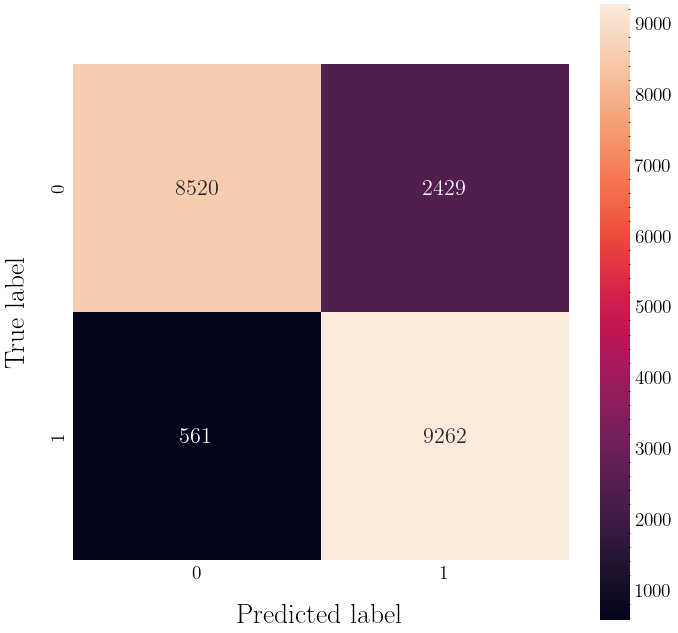

In [37]:
display_confusion_matrix(y_test, y_pred_test_shallow)

In [38]:
display_classification_score(y_train, y_pred_train_shallow)

,Metric,Score
0,Accuracy,0.854280
1,Precision,0.790800
2,Recall,0.941880
3,F1,0.859753


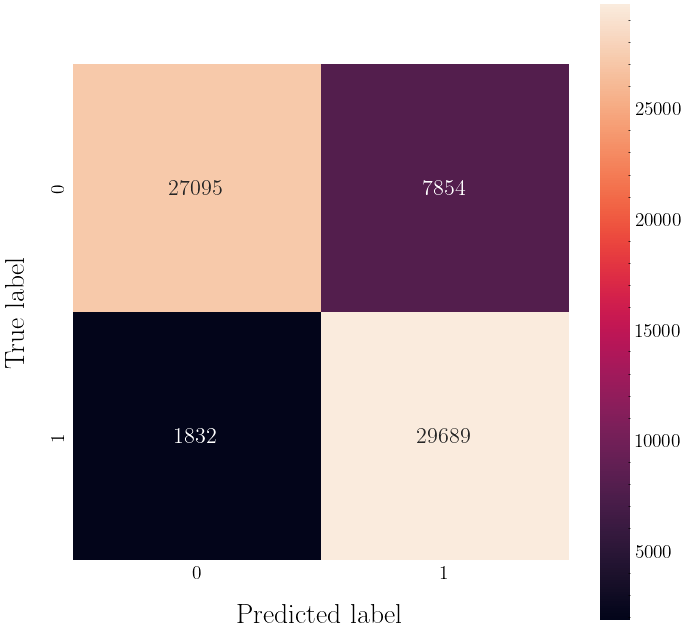

In [39]:
display_confusion_matrix(y_train, y_pred_train_shallow)

$$ \text{\Large{Model interpretation}} $$

In [40]:
pi = permutation_importance(
    model_shallow,
    X=X_test,
    y=y_test,
    scoring='accuracy',
    n_repeats=30
)

df_importance = pd.DataFrame(
    {
        'variable': X_test.columns,
        'importance': pi.importances_mean.round(4),
        'sd': pi.importances_std.round(4)
    }
)

df_importance.sort_values(by='importance', ascending=False)

,variable,importance,sd
4,absolute_magnitude,0.3784,0.0034
2,relative_velocity,0.0180,0.0011
3,miss_distance,0.0112,0.0012
0,est_diameter_min,0.0091,0.0012
1,est_diameter_max,0.0091,0.0012


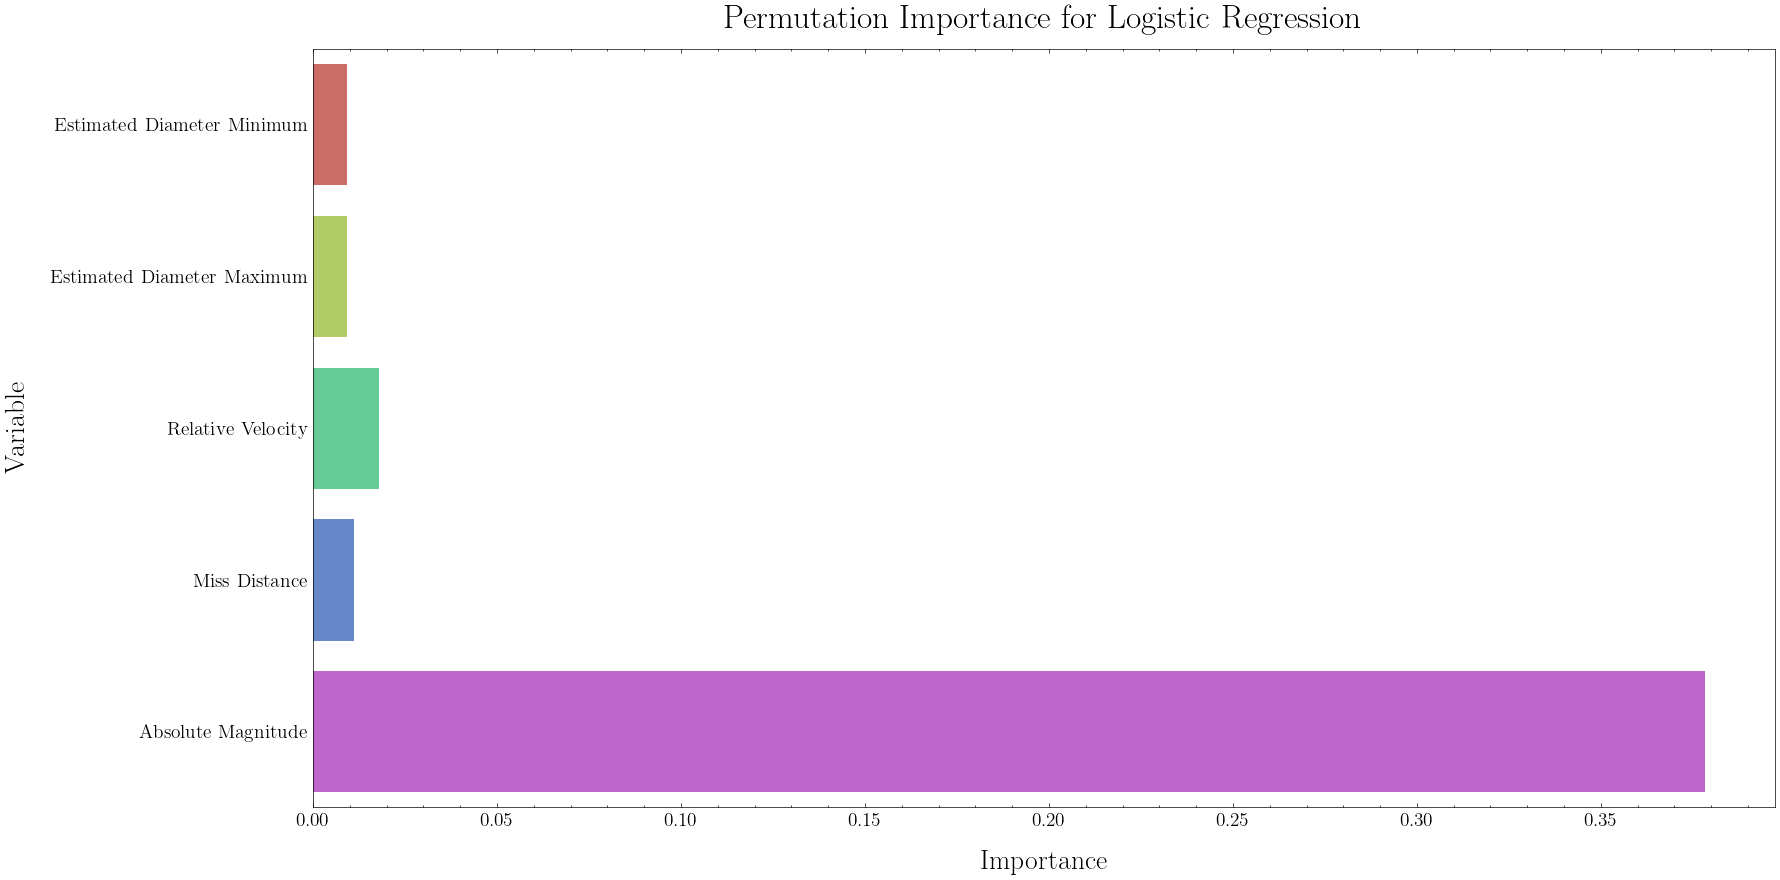

In [41]:
display_permutation_importance(df_importance, name='Logistic Regression')

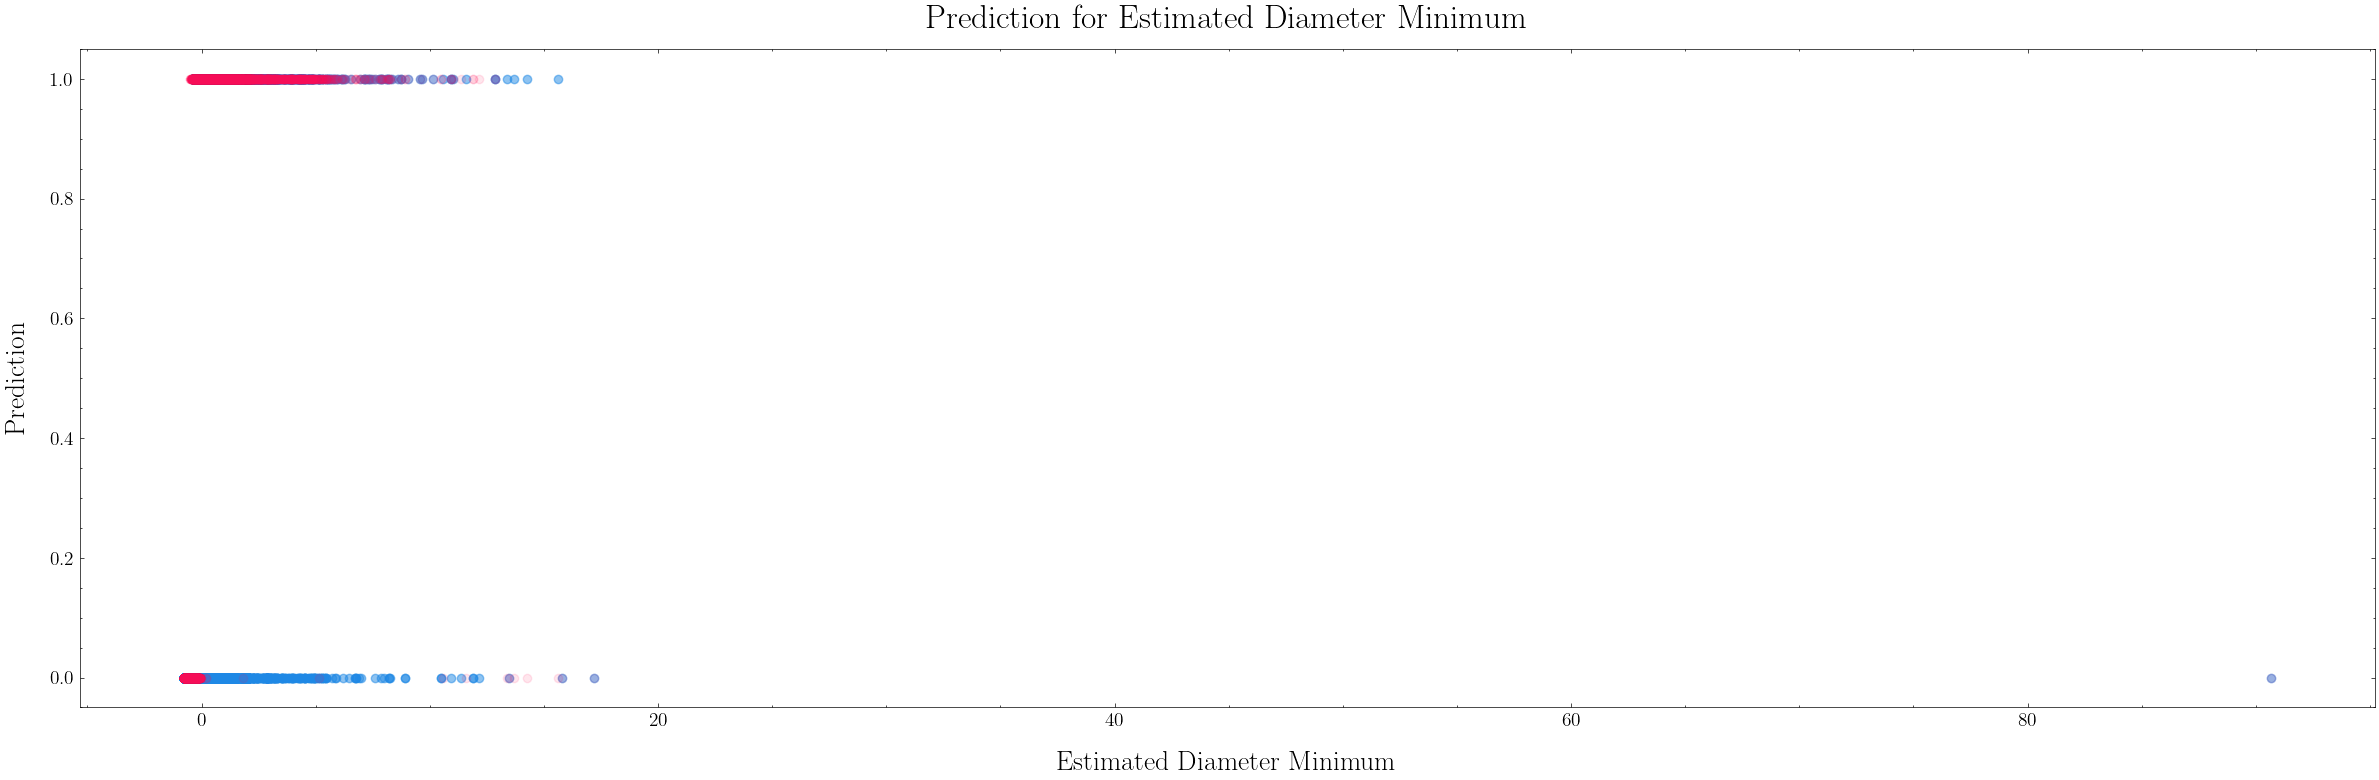

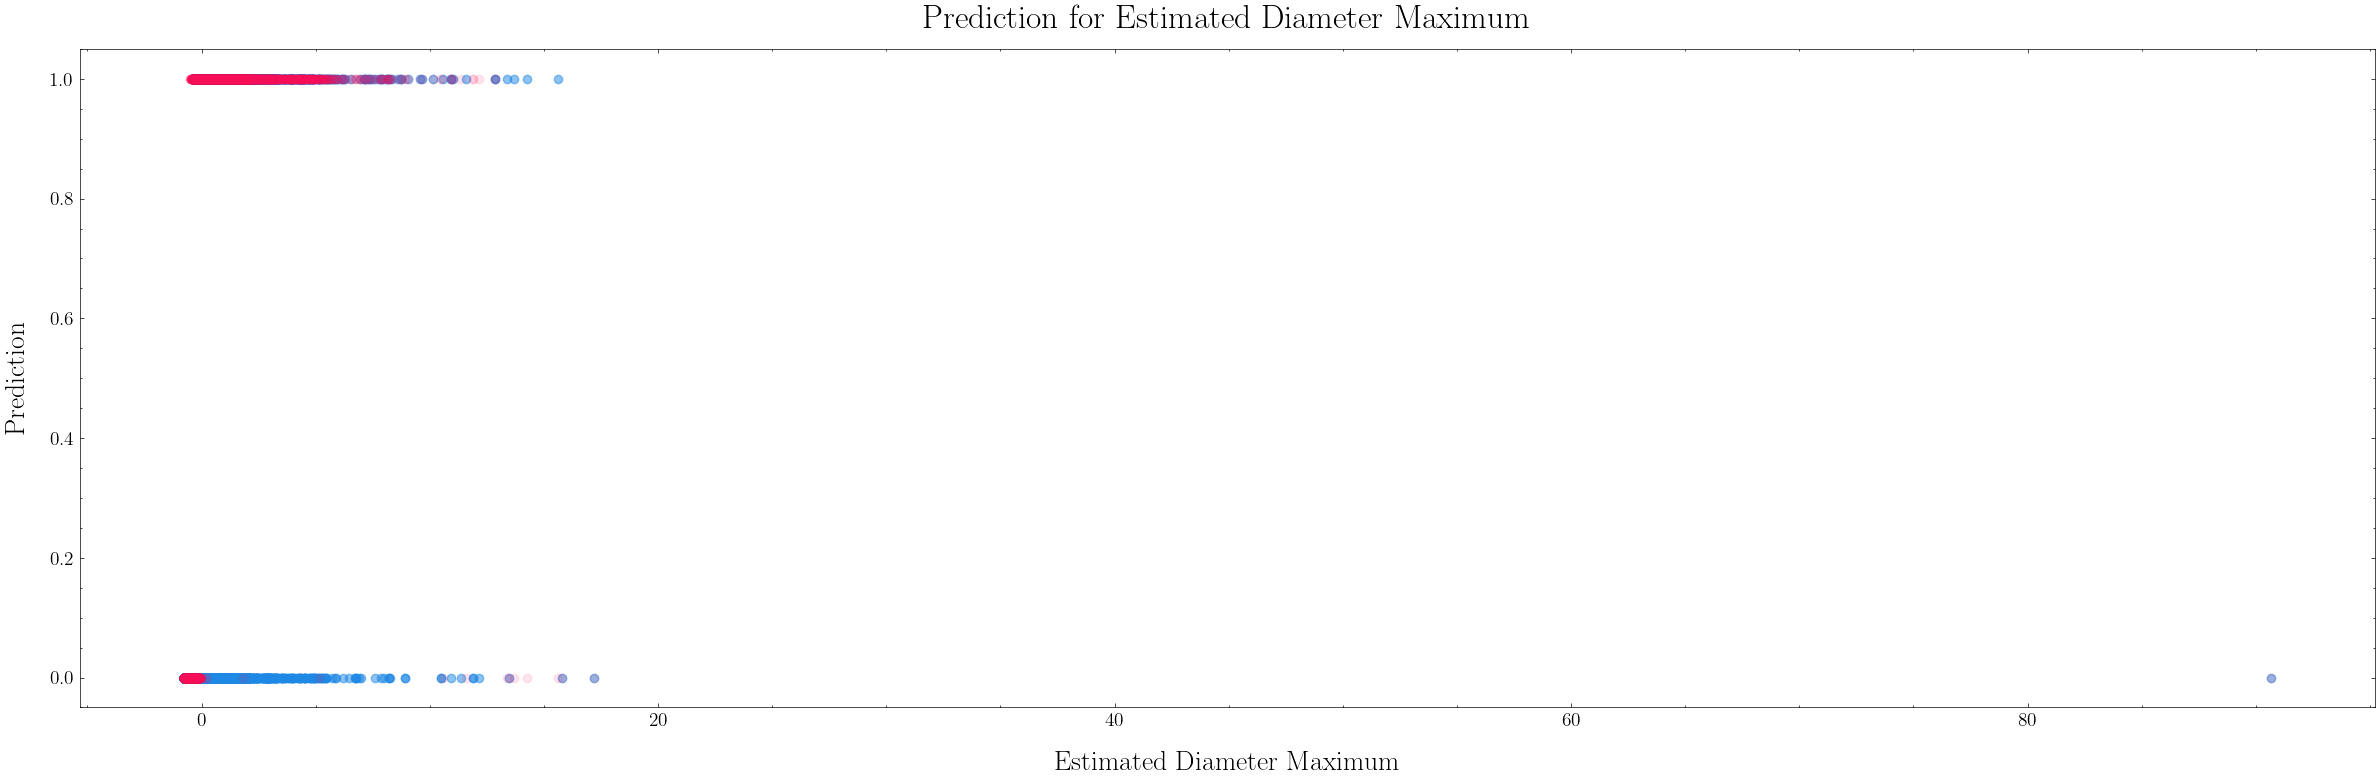

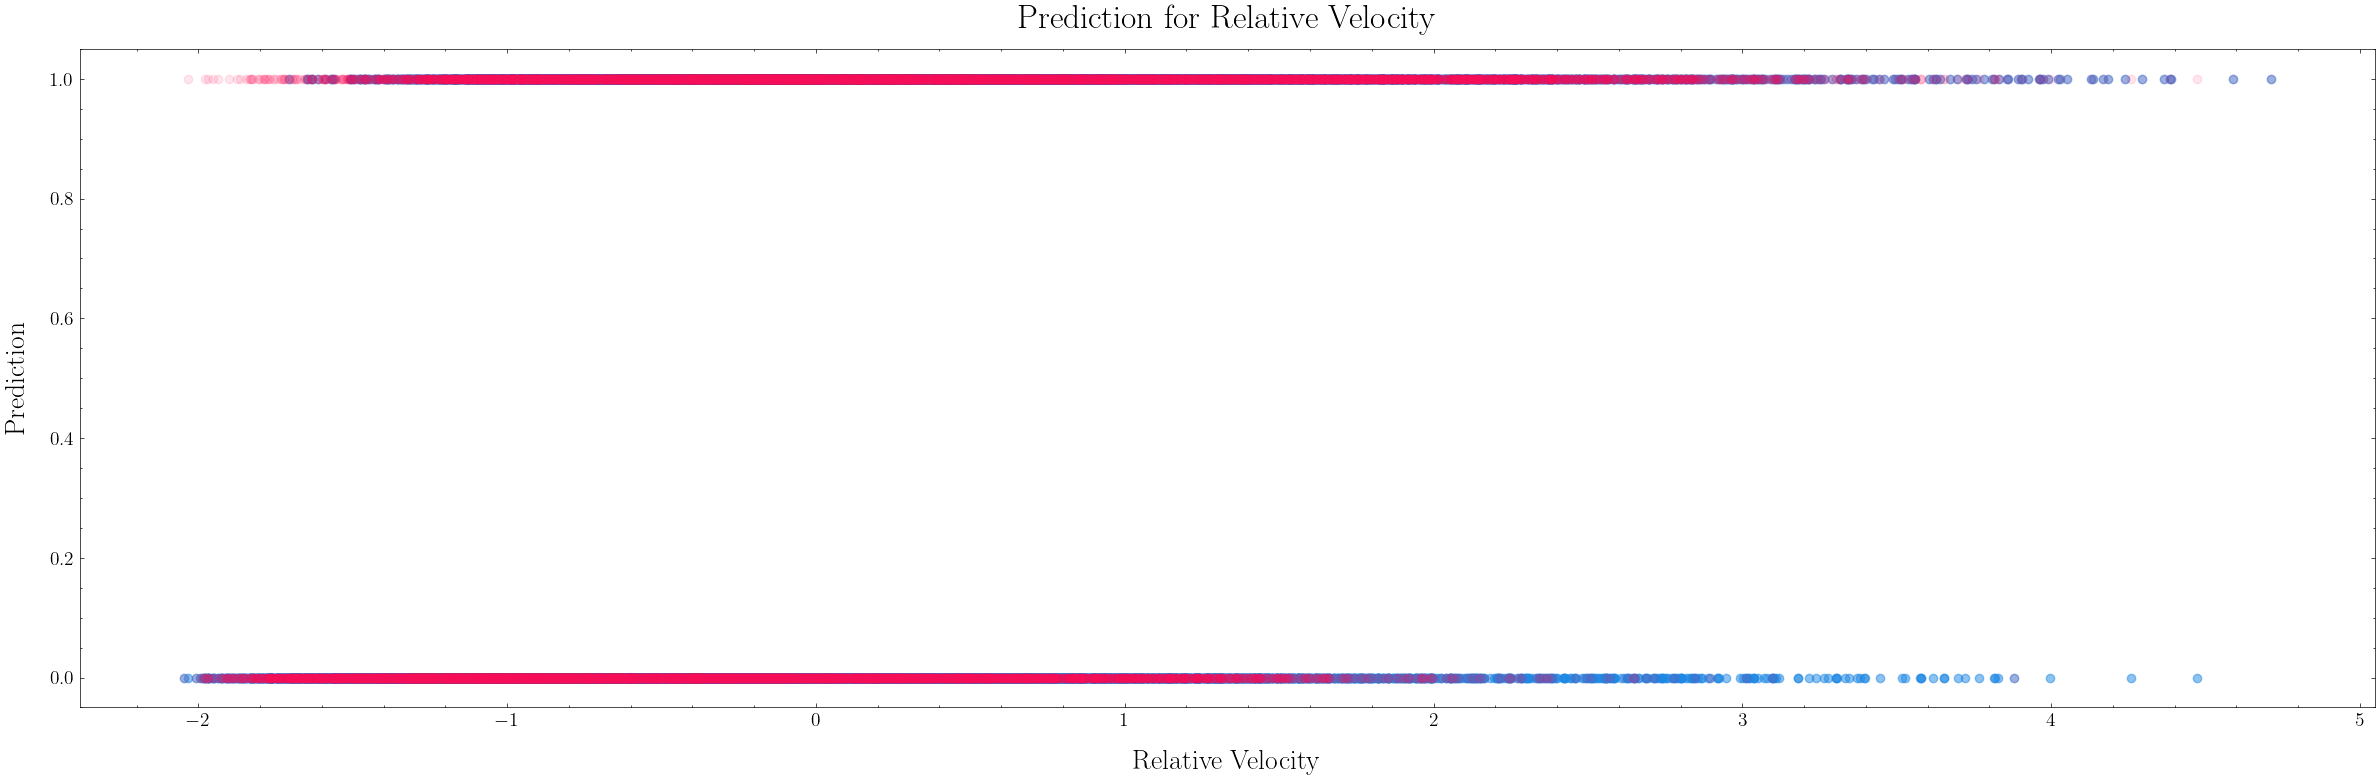

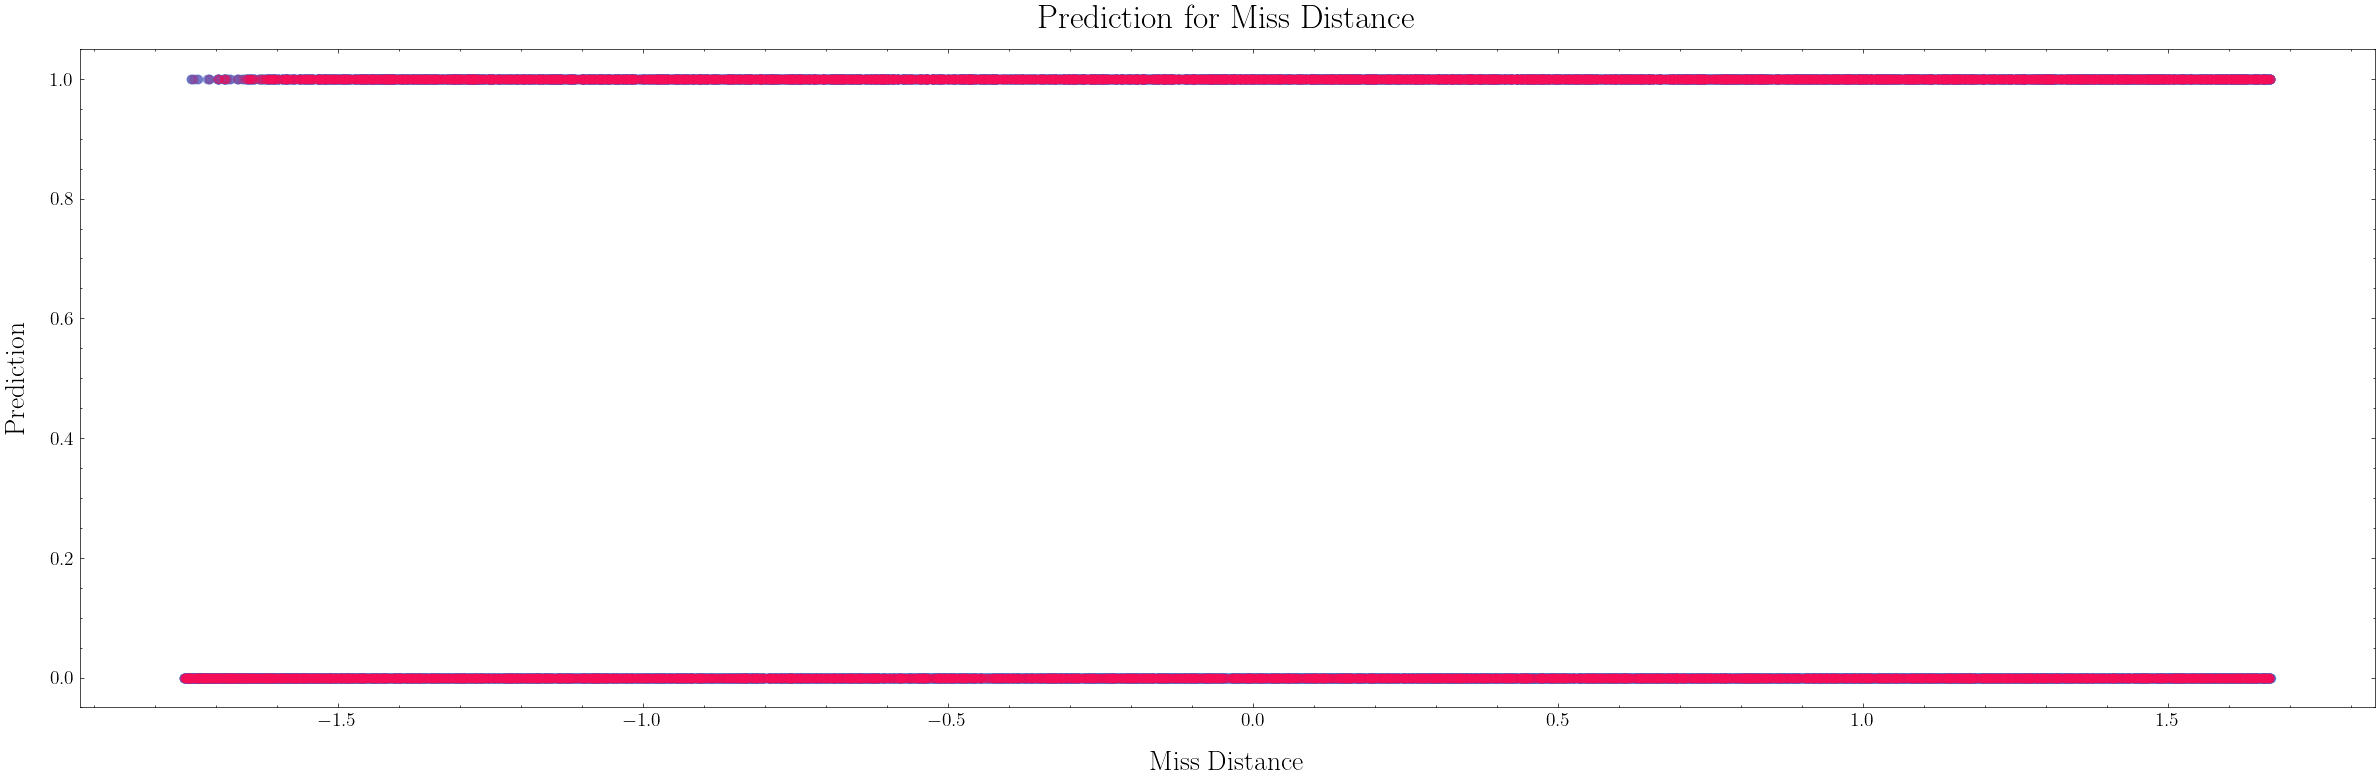

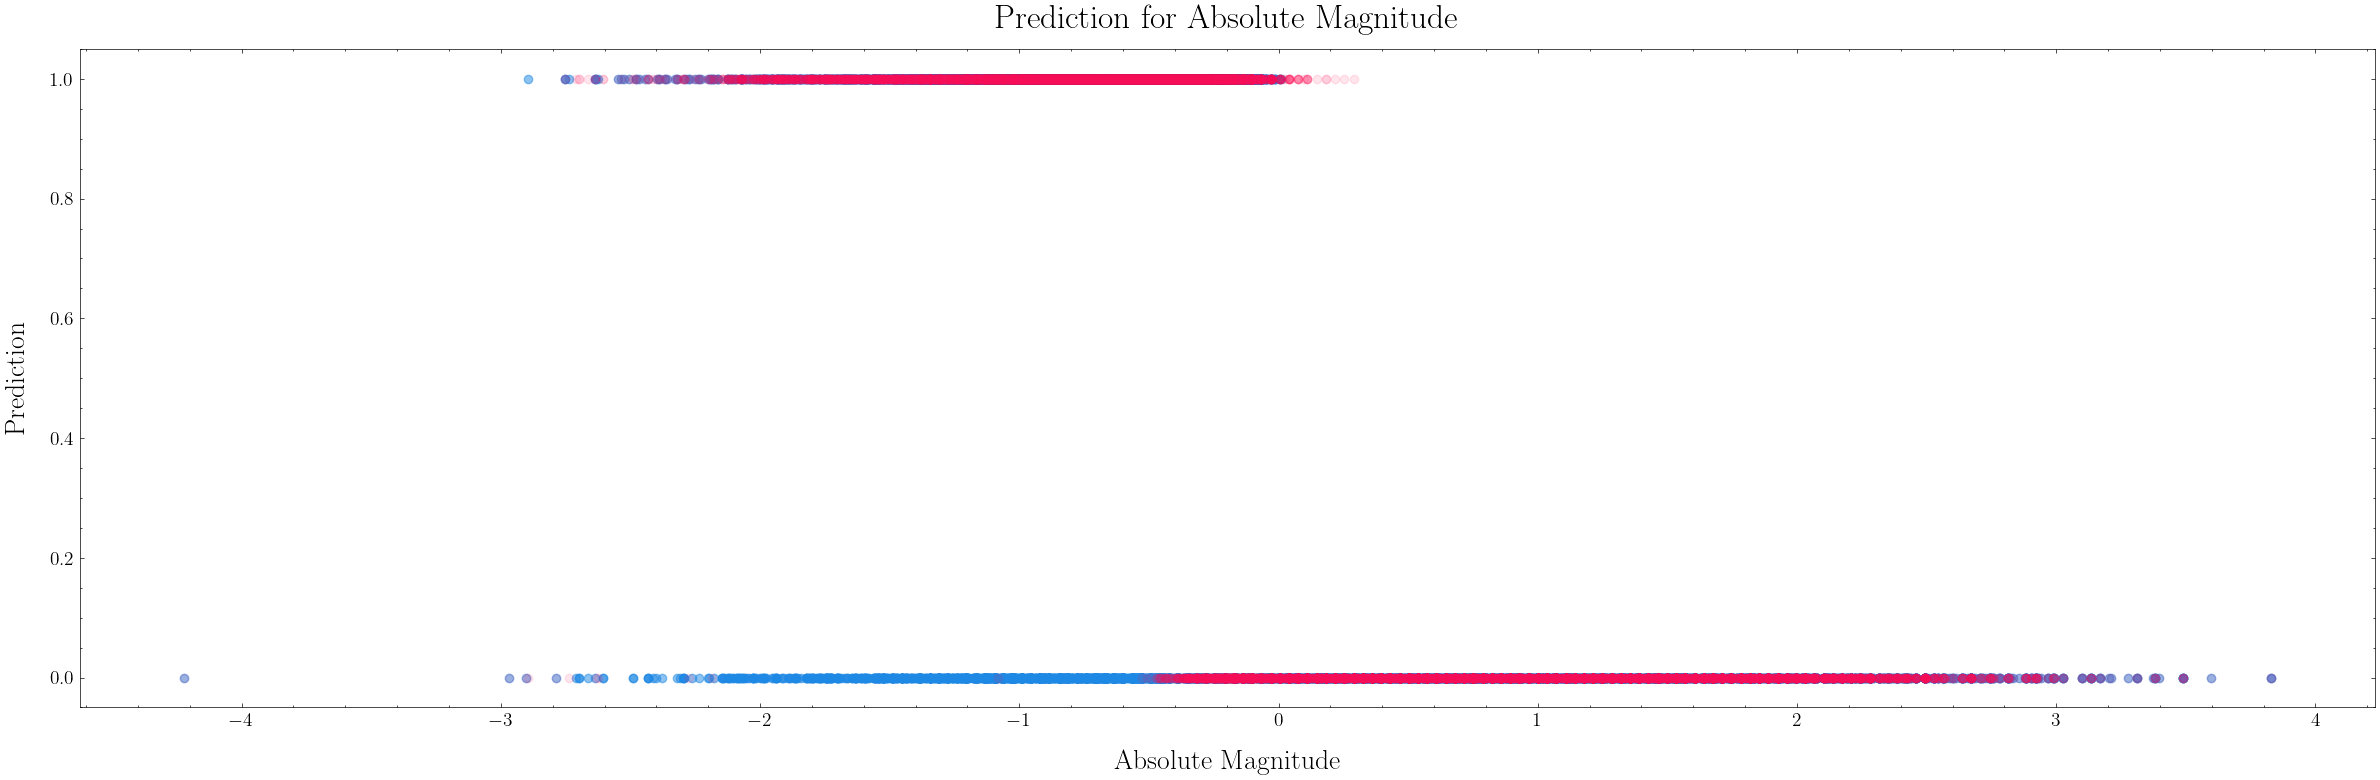

In [42]:
for column in numerical.columns:
    figsize = (24, 8)
    fig, ax = plt.subplots(figsize=figsize)
    
    ax.scatter(
        x=X_test[column],
        y=y_test,
        color='#1e88e5',
        alpha=0.50
    )

    ax.scatter(
        x=X_test[column],
        y=y_pred_test_shallow,
        color='#ff0d57',
        alpha=0.10
    )

    column = column_to_title(column)

    ax.set_ylabel('Prediction')
    ax.set_xlabel(column)
    
    ax.set_title(f"Prediction for {column}")

    plt.tight_layout()
    plt.show()
    
    print('\n \n')

plt.close('all')

$$ \text{\Large{Before Resampling}} $$
- The model struggled to identify if the asteroid was hazardous based on each variable. There wasn't much variability between predicted vs. observed.
    - We assumed it was due to the imbalance of our target variable.
- The model was able to predict if the asteroid was **not** hazardous based on each variable.

$$ \text{\Large{After Resampling}} $$
- The model was able to predict if the asteroid was hazardous **and** not hazardous based on each variable.
    - The model struggled in predicting if the asteroid was **not** hazardous based on:
        - higher values of minimum and maximum asteroid diameter and relative velocity.
        - lower values of absolute magnitude
- There was *some* variability between predicted vs. observed (i.e., Relative Velocity, Absolute Magnitude).
- The model did well in it's prediction in the *Miss Distance* plot.

$$ \text{\Huge{Deep learning}} $$

$$ \text{\Large{Model building}} $$

In [43]:
def hypermodel(hp):
    hypermodel = Sequential()

    layers = hp.Int('num_layers', 1, 10)

    for layer in range(layers):
        units = hp.Int(
            'units',
            min_value=32,
            max_value=512,
            step=32
        )

        activation = hp.Choice(
            'activation',
            ['relu']
        )

        hypermodel.add(
            Dense(units=units, activation=activation)
        )

    hypermodel.add(
        Dense(1, activation='sigmoid')
    )

    learning_rate = hp.Choice(
        'learning_rate',
        values=[1e-2, 1e-3, 1e-4]
    )

    hypermodel.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss=BinaryCrossentropy(),
        metrics=['accuracy']
    )

    return hypermodel

We attempted to use hyperparameter tuning from Keras Tuner. We used a relatively simple configuration, which consisted of:
1. A range from 1 to 10 `Dense` layers
    - A range from 32 to 512 units and a step 32 between each unit
    - We used the `relu` activation function for each hidden layer
2. A single output layer
    - A single unit
    - We used the `sigmoid` activation function for the output layer
3. The `Adam` optimizer
    - A range from 1e-2 to 1e-4 for the learning rate
4. The `BinaryCrossentropy` loss function, due to it's prevalence in binary classification
5. The performance of the model was measured in terms of it's accuracy

In [44]:
hypermodel(
    HyperParameters()
)

tuner = Hyperband(
    hypermodel=hypermodel,
    factor=3,
    max_epochs=20,
    objective='val_accuracy',
    overwrite=True,
    directory='tuning/',
    project_name='neo'
)

tuner.search_space_summary()

callbacks = [
    EarlyStopping(
        monitor='val_loss',
        patience=5
    )
]

tuner.search(
    X_train,
    y_train,
    callbacks=callbacks,
    epochs=20,
    batch_size=32,
    validation_data=(X_val, y_val),
    validation_split=0.2
)

Trial 30 Complete [00h 00m 58s]
val_accuracy: 0.8814538717269897

Best val_accuracy So Far: 0.8850643634796143
Total elapsed time: 00h 13m 32s


In an attempt to optimize (and speed-up) the training process, we used the `EarlyStopping()` callback to monitor `val_loss`, which would stop training, if there was no improvement after 5 epochs (illustrated by `patience=5`).

In [45]:
hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]

We set `num_trials=1` to get a single Hyperparameter object, which will return the best configuration of hyperparameters.

In [46]:
model_deep = tuner.hypermodel.build(hyperparameters)

history = model_deep.fit(
    X_train,
    y_train,
    epochs=20,
    validation_split=0.2
)

per_epoch = history.history['val_accuracy']

epochs = per_epoch.index(
    max(per_epoch)
) + 1

Epoch 1/20
1662/1662 [==============================] - 4s 2ms/step - loss: 0.3175 - accuracy: 0.8658 - val_loss: 0.2910 - val_accuracy: 0.8777
Epoch 2/20
1662/1662 [==============================] - 3s 2ms/step - loss: 0.2986 - accuracy: 0.8726 - val_loss: 0.2910 - val_accuracy: 0.8758
Epoch 3/20
1662/1662 [==============================] - 3s 2ms/step - loss: 0.2945 - accuracy: 0.8731 - val_loss: 0.2869 - val_accuracy: 0.8766
Epoch 4/20
1662/1662 [==============================] - 3s 2ms/step - loss: 0.2899 - accuracy: 0.8738 - val_loss: 0.2788 - val_accuracy: 0.8787
Epoch 5/20
1662/1662 [==============================] - 3s 2ms/step - loss: 0.2822 - accuracy: 0.8752 - val_loss: 0.2705 - val_accuracy: 0.8794
Epoch 6/20
1662/1662 [==============================] - 3s 2ms/step - loss: 0.2735 - accuracy: 0.8753 - val_loss: 0.2665 - val_accuracy: 0.8793
Epoch 7/20
1662/1662 [==============================] - 3s 2ms/step - loss: 0.2669 - accuracy: 0.8766 - val_loss: 0.2573 - val_accuracy:

We re-trained the model to find the optimal number of epochs based on `val_accuracy`.

In [47]:
model_deep = tuner.hypermodel.build(hyperparameters)

history = model_deep.fit(
    X_train,
    y_train,
    epochs=epochs,
    validation_split=0.2
)

Epoch 1/17
1662/1662 [==============================] - 3s 2ms/step - loss: 0.3178 - accuracy: 0.8678 - val_loss: 0.2949 - val_accuracy: 0.8745
Epoch 2/17
1662/1662 [==============================] - 3s 2ms/step - loss: 0.2982 - accuracy: 0.8729 - val_loss: 0.2883 - val_accuracy: 0.8784
Epoch 3/17
1662/1662 [==============================] - 3s 2ms/step - loss: 0.2944 - accuracy: 0.8731 - val_loss: 0.2824 - val_accuracy: 0.8797
Epoch 4/17
1662/1662 [==============================] - 3s 2ms/step - loss: 0.2893 - accuracy: 0.8741 - val_loss: 0.2780 - val_accuracy: 0.8790
Epoch 5/17
1662/1662 [==============================] - 3s 2ms/step - loss: 0.2818 - accuracy: 0.8745 - val_loss: 0.2823 - val_accuracy: 0.8740
Epoch 6/17
1662/1662 [==============================] - 3s 2ms/step - loss: 0.2734 - accuracy: 0.8759 - val_loss: 0.2671 - val_accuracy: 0.8799
Epoch 7/17
1662/1662 [==============================] - 3s 2ms/step - loss: 0.2642 - accuracy: 0.8764 - val_loss: 0.2570 - val_accuracy:

Re-build and re-fit the model using the most optimal epochs and hyperparameters from search.

$$ \text{\Large{Model testing}} $$

$$ \text{\Large{Scoring}} $$

In [48]:
loss, accuracy = model_deep.evaluate(X_test, y_test)
display_deep_score(loss, accuracy)

650/650 [==============================] - 1s 955us/step - loss: 0.2357 - accuracy: 0.8808


,Metric,Score
0,Loss,0.235651
1,Accuracy,0.880753


In [49]:
loss, accuracy = model_deep.evaluate(X_train, y_train)
display_deep_score(loss, accuracy)

2078/2078 [==============================] - 2s 965us/step - loss: 0.2319 - accuracy: 0.8805


,Metric,Score
0,Loss,0.231904
1,Accuracy,0.880487


In [50]:
y_pred_test_deep = model_deep.predict(X_test)

650/650 [==============================] - 0s 628us/step


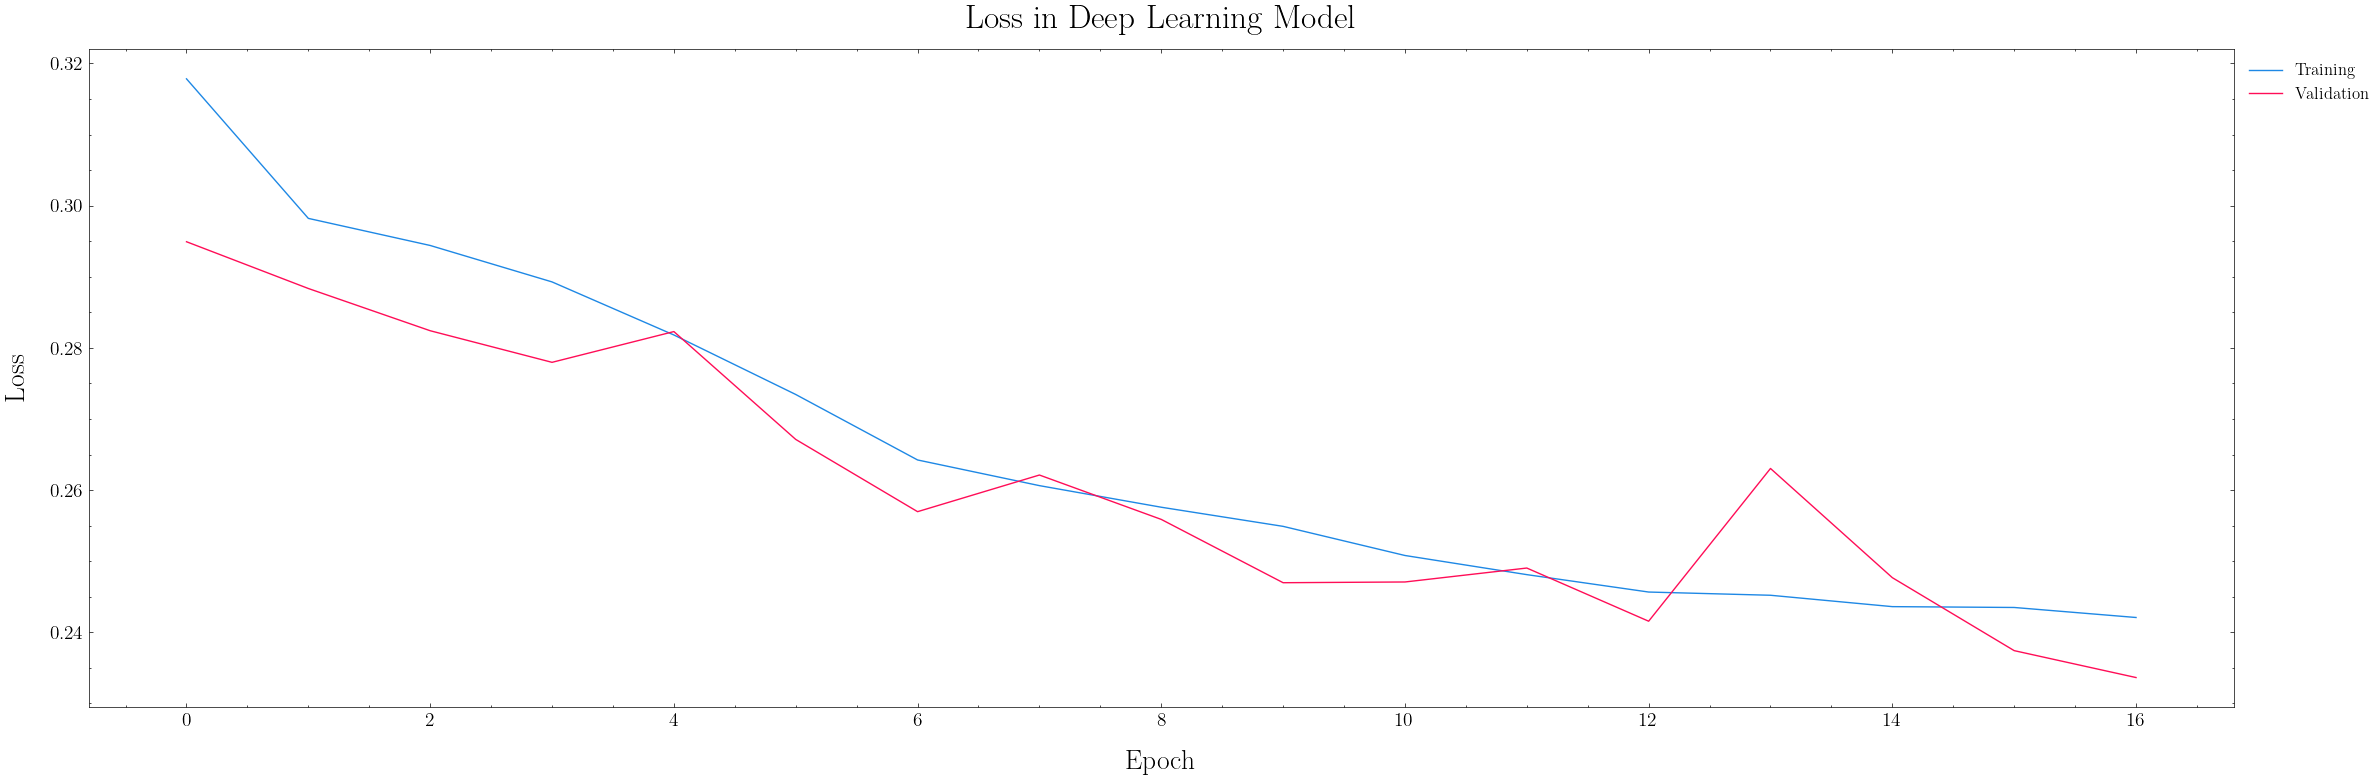

In [51]:
figsize = (24, 8)
fig, ax = plt.subplots(figsize=figsize)

plt.plot(
    history.history['loss'],
    color='#1e88e5',
    label='Training'
)

plt.plot(
    history.history['val_loss'],
    color='#ff0d57',
    label='Validation'
)

ax.set_title('Loss in Deep Learning Model')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')

plt.legend(
    loc='upper left', 
    bbox_to_anchor=(1, 1)
)

plt.tight_layout()

file = path.joinpath('loss.png')
fig.savefig(file, format='png')

plt.show()
plt.close()

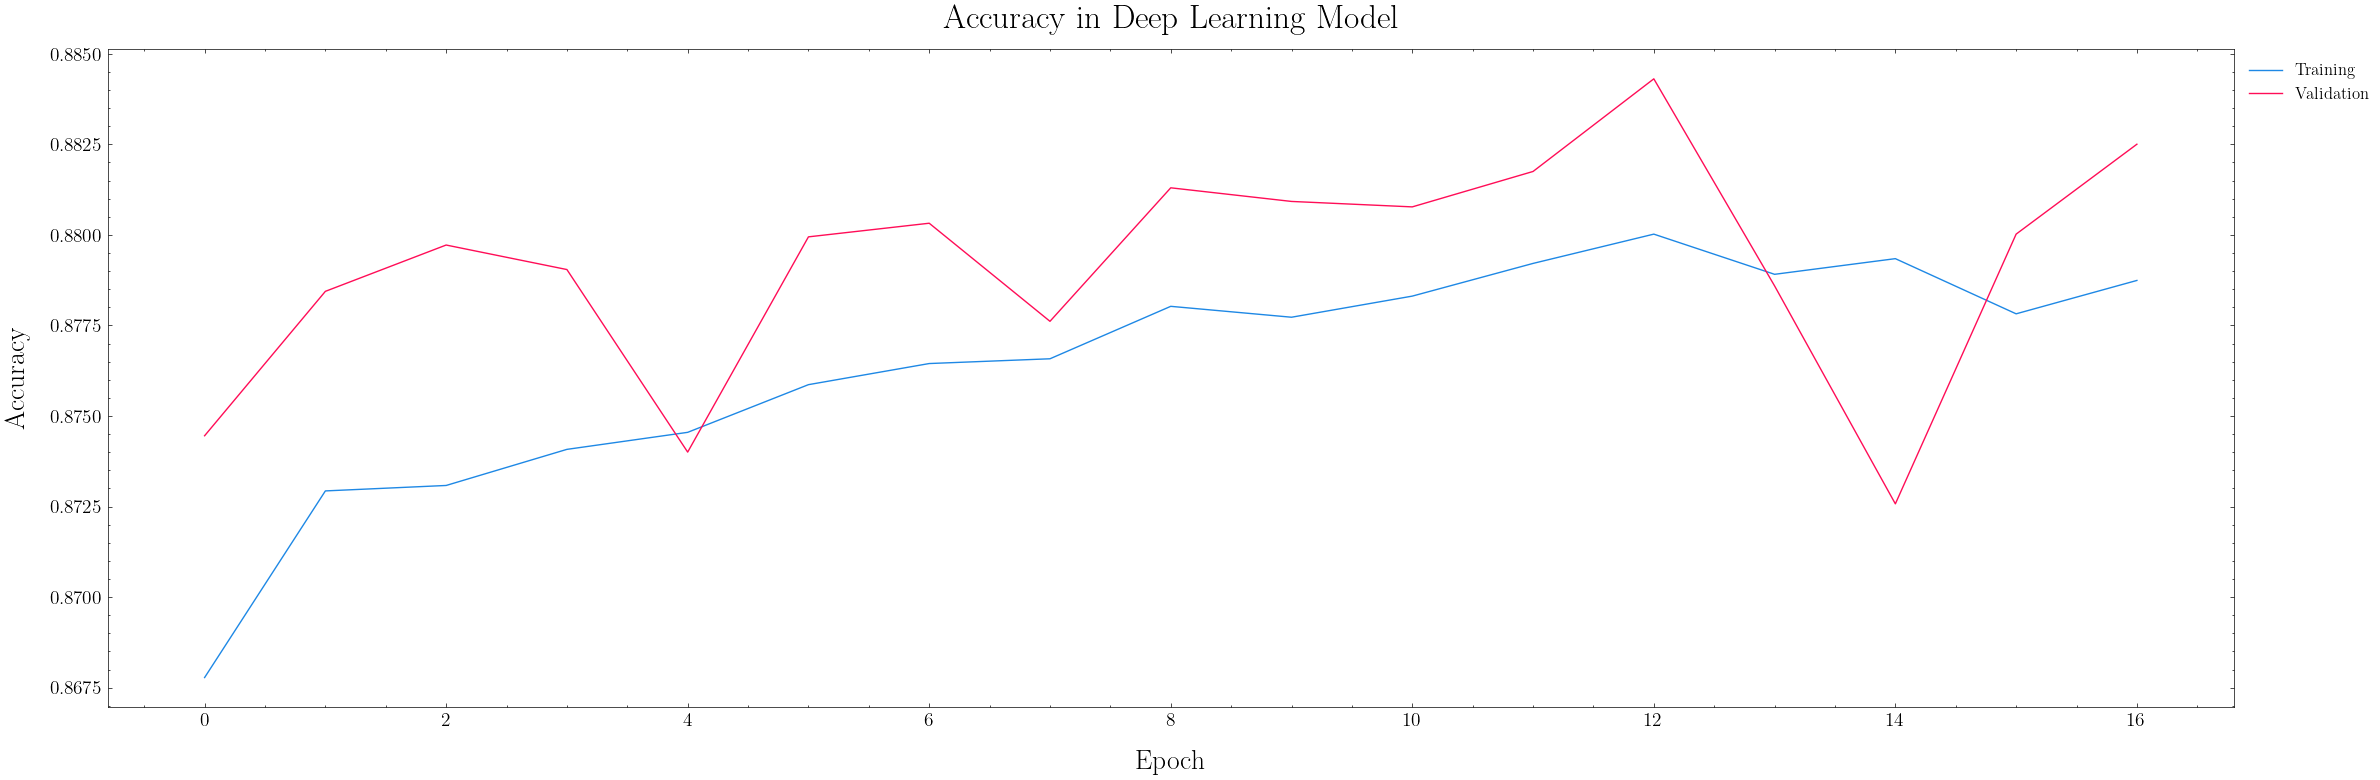

In [52]:
figsize = (24, 8)
fig, ax = plt.subplots(figsize=figsize)

plt.plot(
    history.history['accuracy'],
    color='#1e88e5',
    label='Training'
)

plt.plot(
    history.history['val_accuracy'],
    color='#ff0d57',
    label='Validation'
)

ax.set_title('Accuracy in Deep Learning Model')
ax.set_xlabel('Epoch')
ax.set_ylabel('Accuracy')

plt.legend(
    loc='upper left', 
    bbox_to_anchor=(1, 1)
)

plt.tight_layout()

file = path.joinpath('accuracy.png')
fig.savefig(file, format='png')

plt.show()
plt.close()

$$ \text{\Large{Model interpretation}} $$

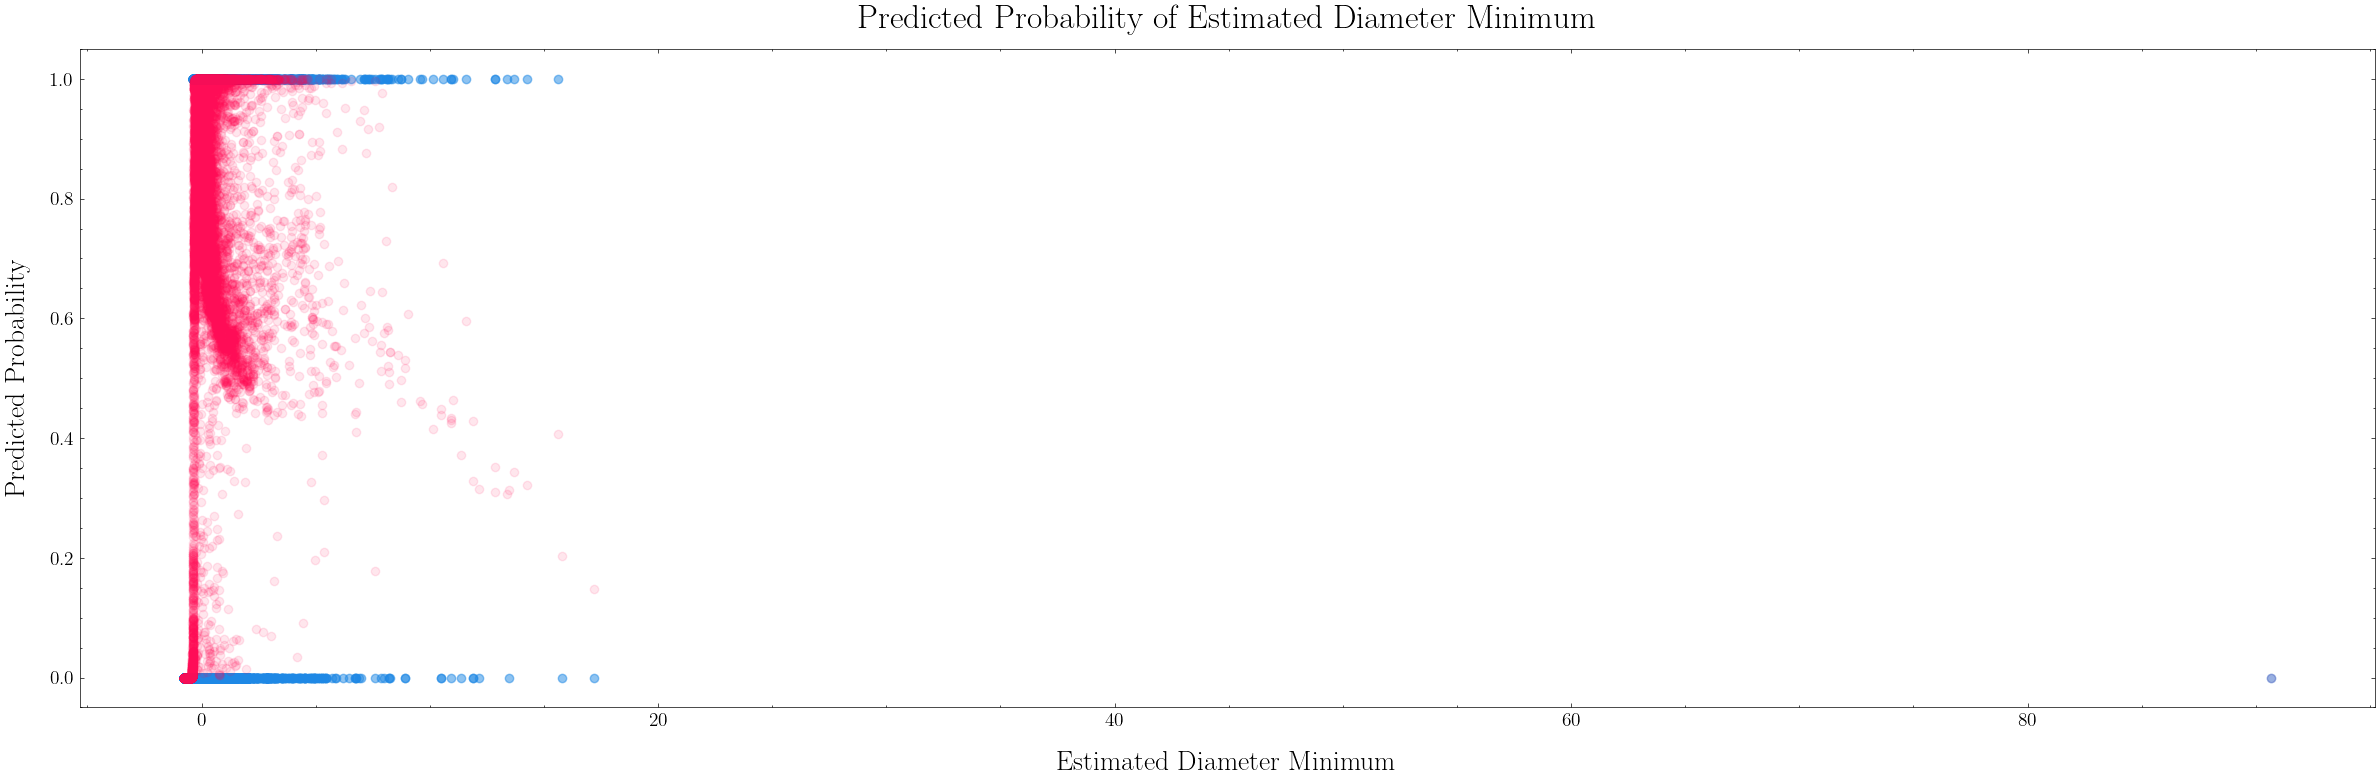

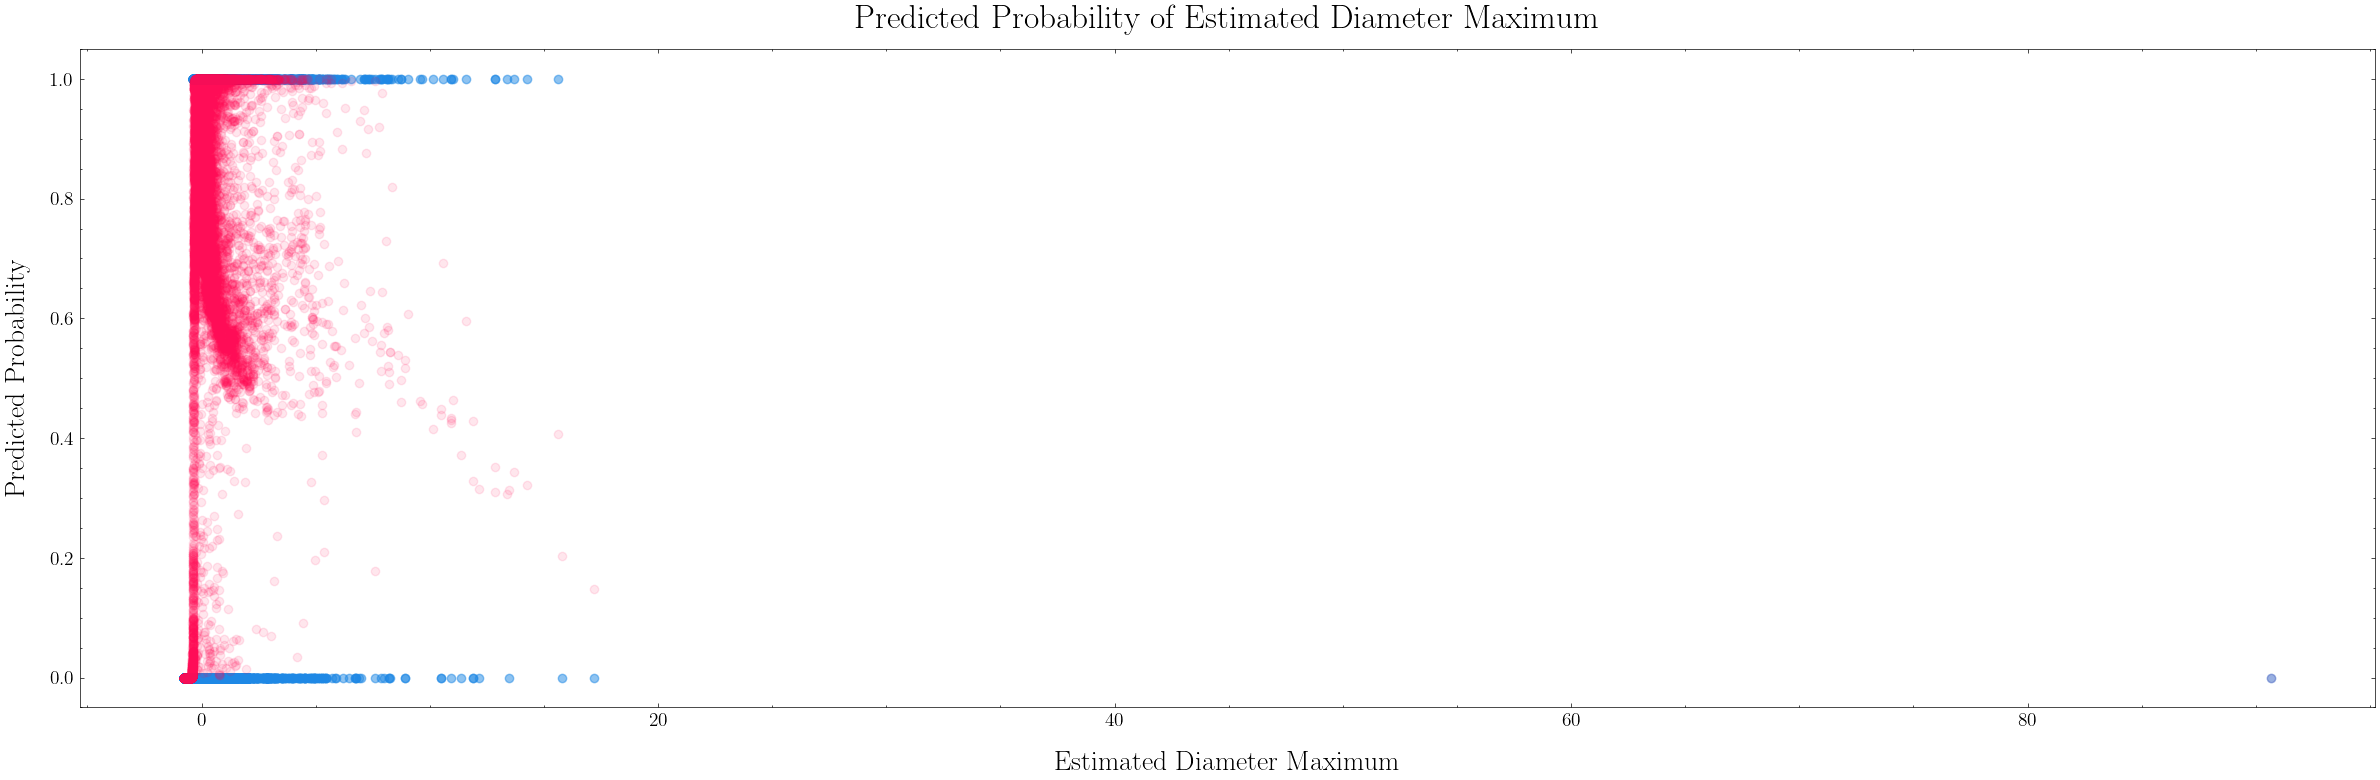

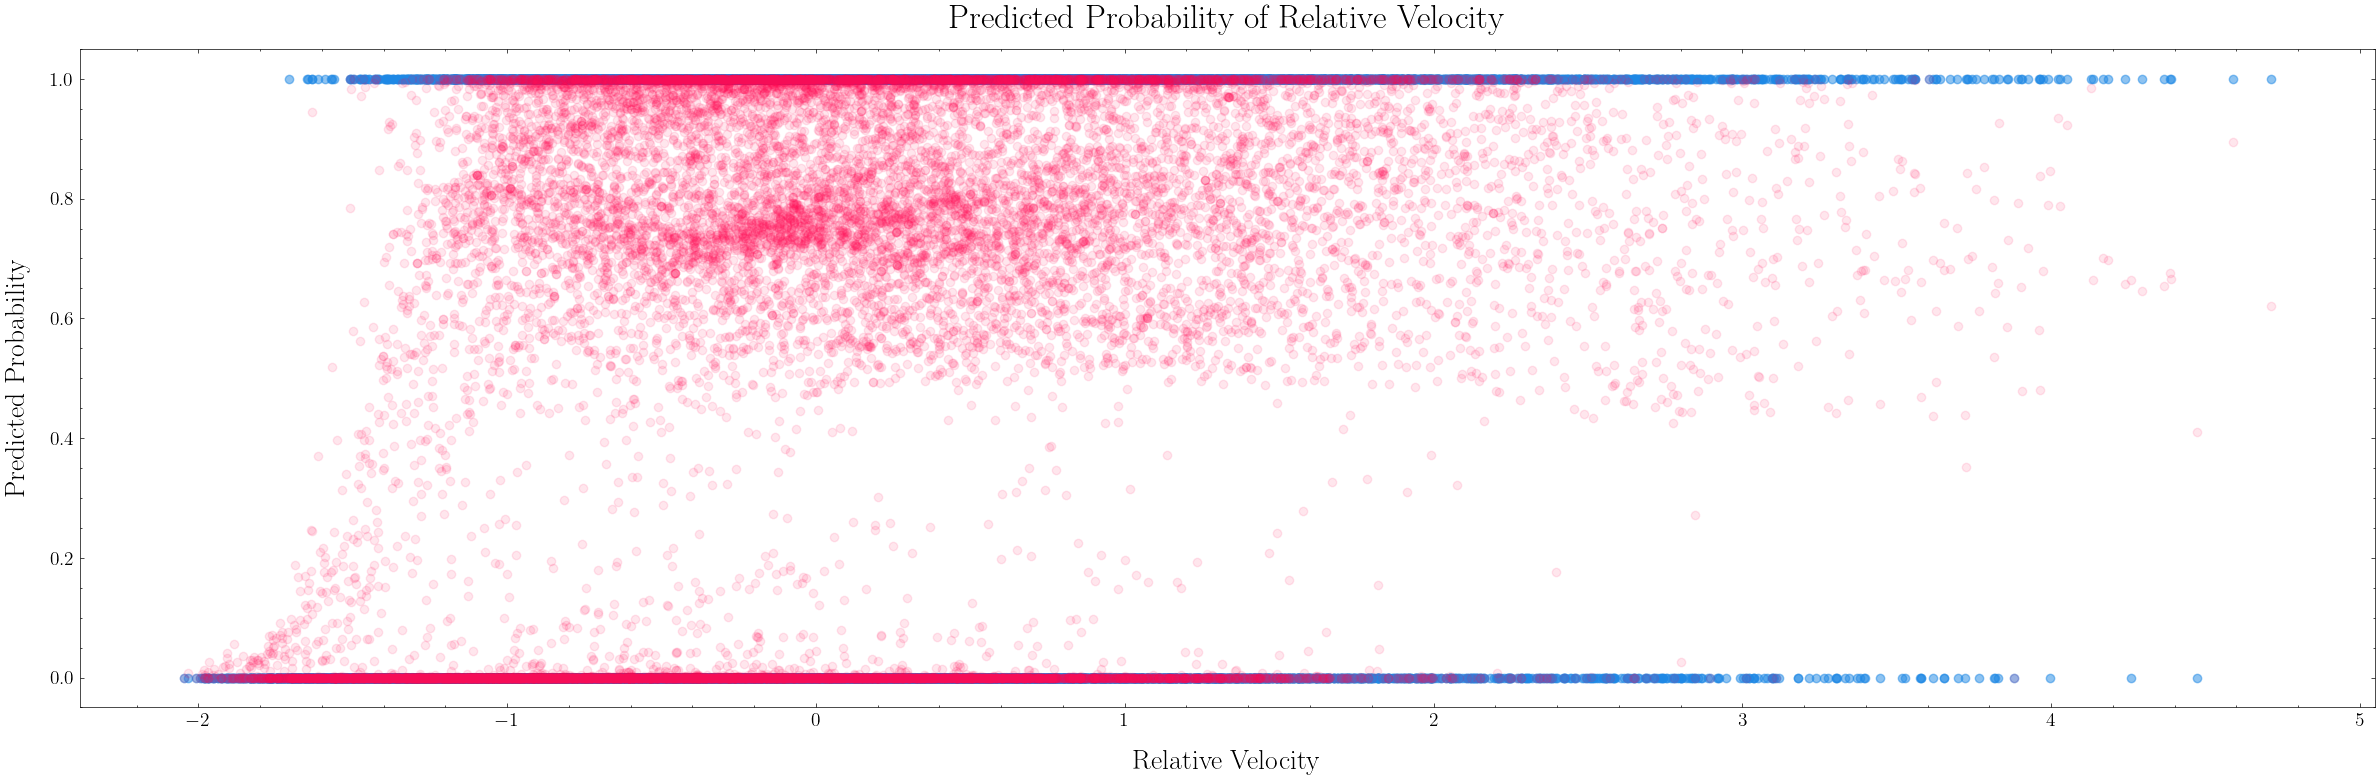

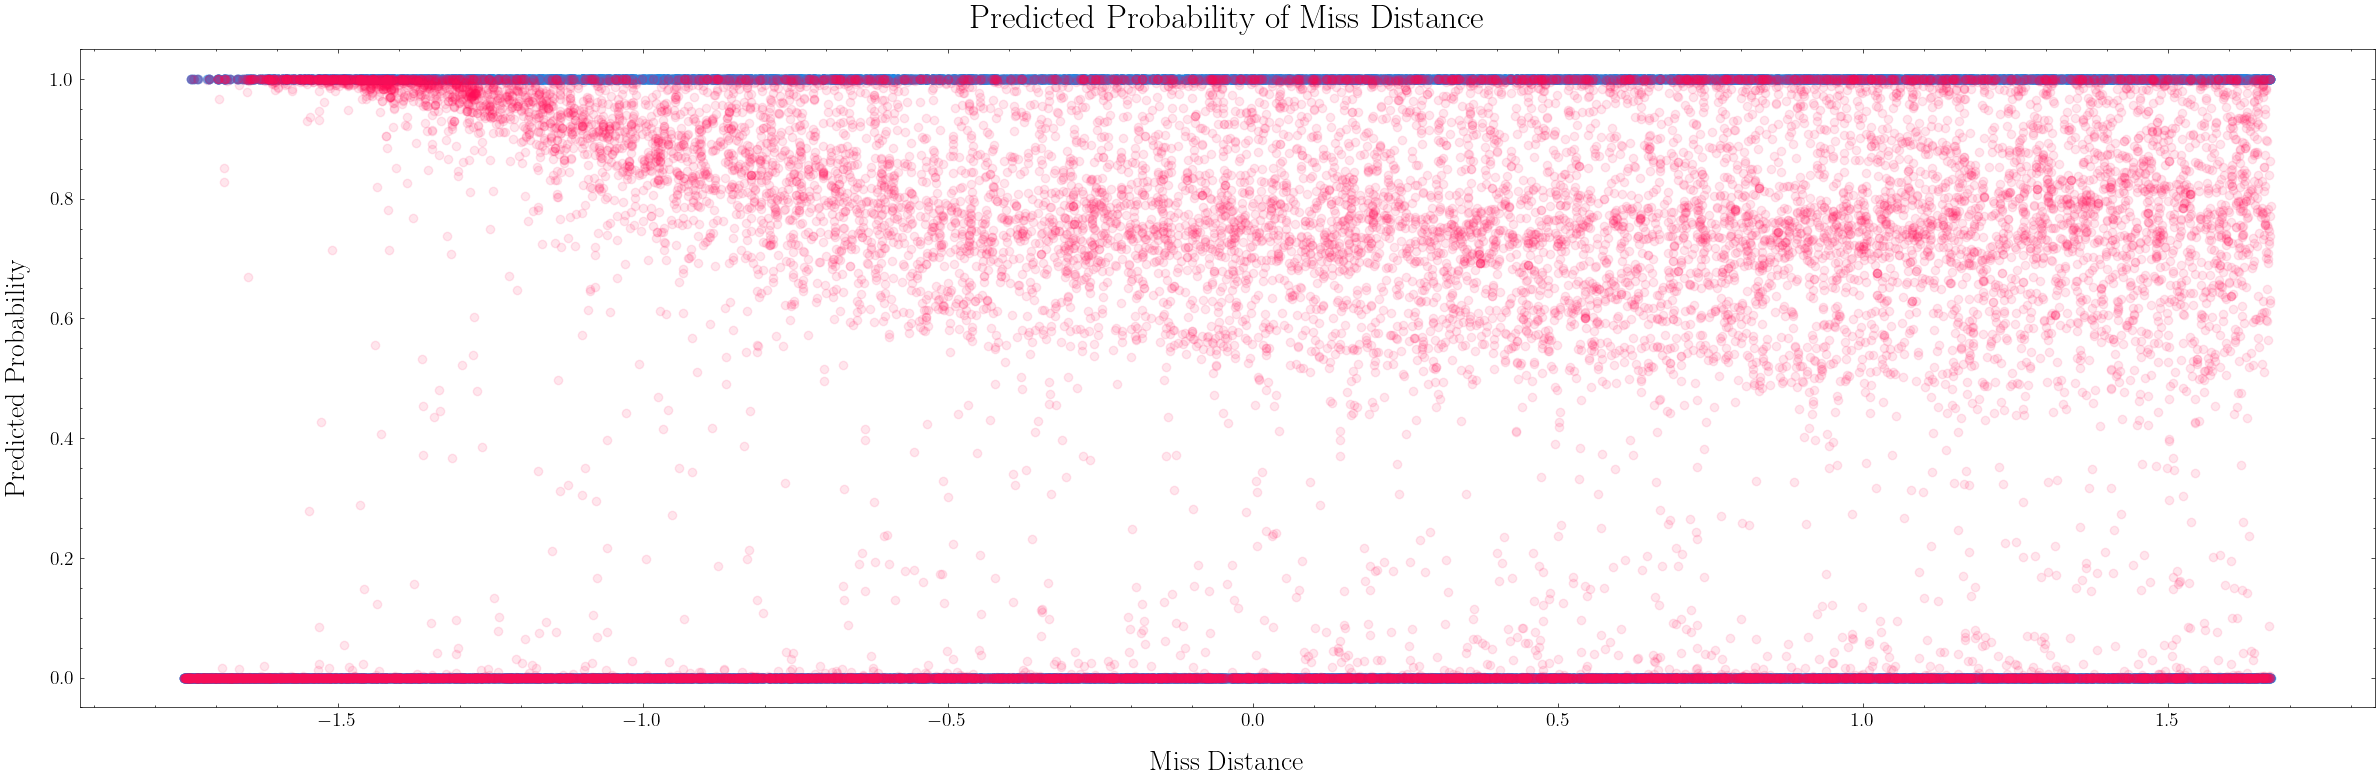

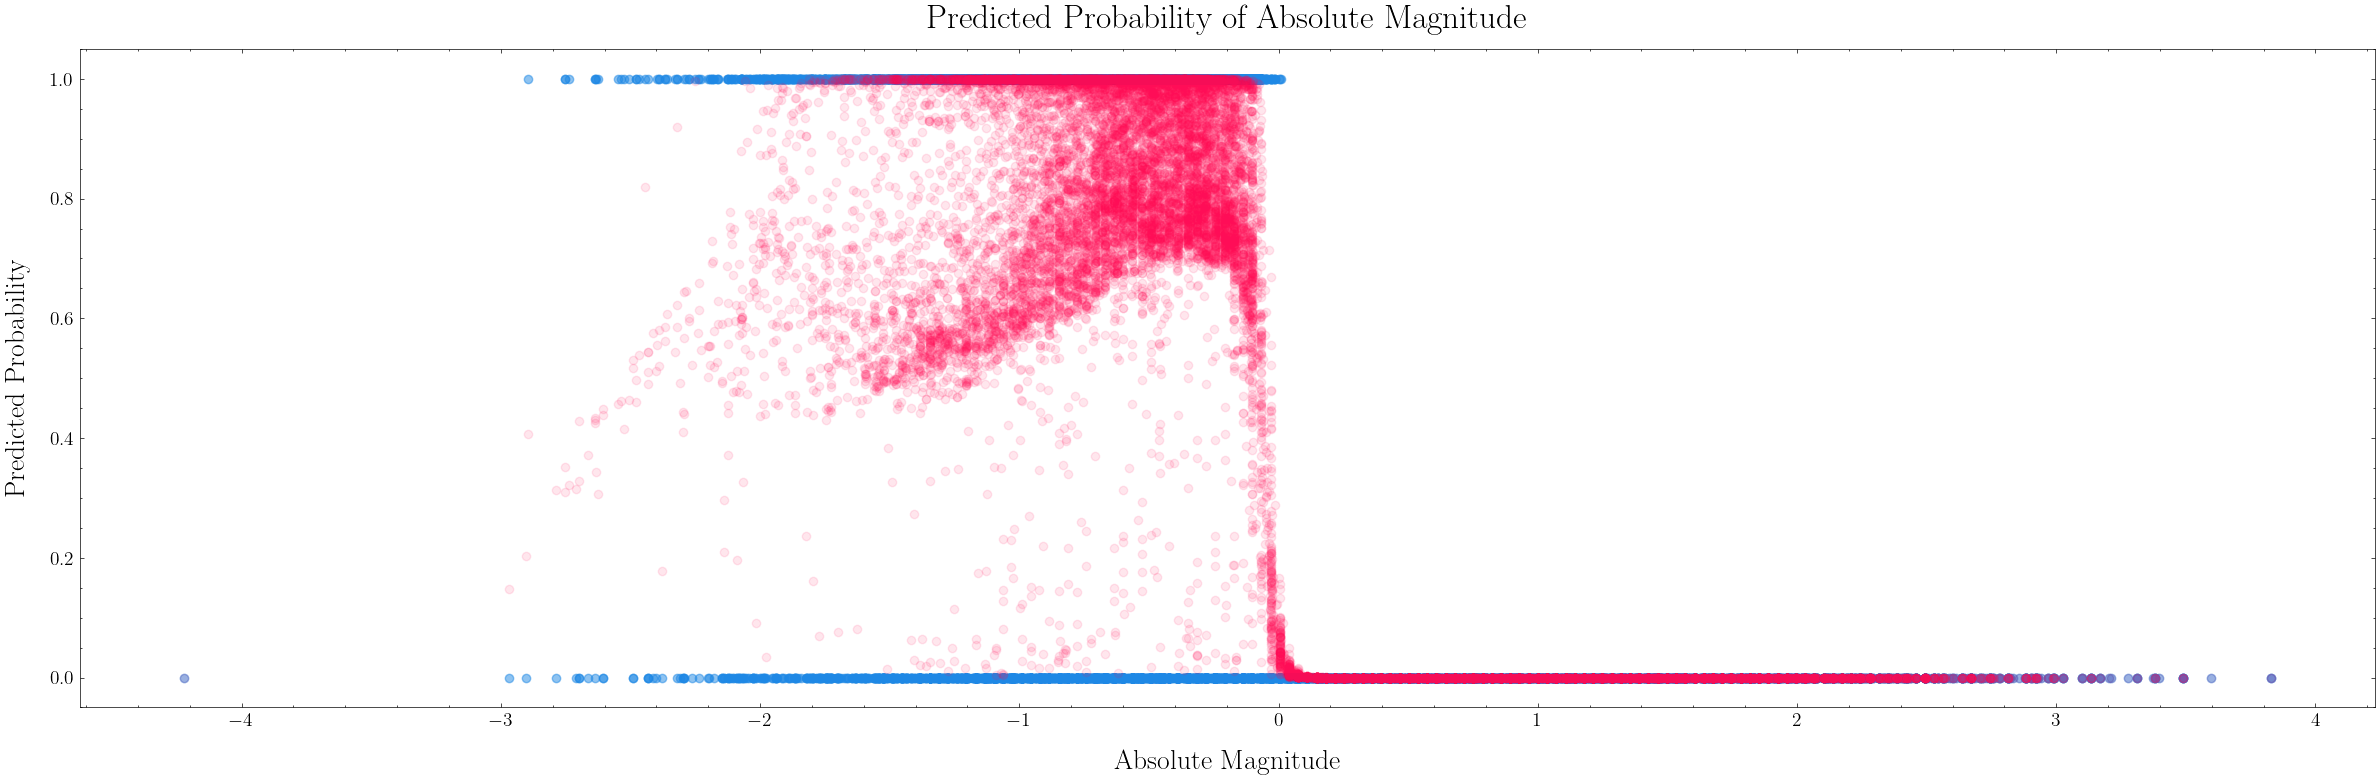

In [53]:
for column in numerical.columns:
    figsize = (24, 8)
    fig, ax = plt.subplots(figsize=figsize)

    ax.scatter(
        x=X_test[column],
        y=y_test,
        color='#1e88e5',
        alpha=0.50
    )

    ax.scatter(
        x=X_test[column],
        y=y_pred_test_deep,
        color='#ff0d57',
        alpha=0.10
    )

    column = column_to_title(column)

    ax.set_ylabel('Predicted Probability')
    ax.set_xlabel(column)

    ax.set_title(f"Predicted Probability of {column}")
    
    plt.tight_layout()
    plt.show()
    
    print('\n \n')

plt.close('all')

Depending on the threshold for our probability, the prediction would change, but if the threshold was at 0.50, then the model would do a decent job. There is a little variance, but the model struggled at the extreme low and high of each variable.

$$ \text{\Large{Experimental Threshold}} $$

We copied the predicted probabilities of our deep learning model, and used `0.90` as a threshold.

- A probability below `0.90` is converted to 0 (False)
- A probability greater than or equal to `0.90` is converted to 1 (True)

In [54]:
y_pred_threshold = y_pred_test_deep.copy()

In [55]:
threshold = 0.90

for probability in y_pred_threshold:
    if probability[0] >= threshold:
        probability[0] = 1
    else:
        probability[0] = 0

z = np.count_nonzero(y_pred_threshold == 0)
o = np.count_nonzero(y_pred_threshold == 1)

print(f"False: {z}")
print(f"True: {o}")

False: 15627
True: 5145


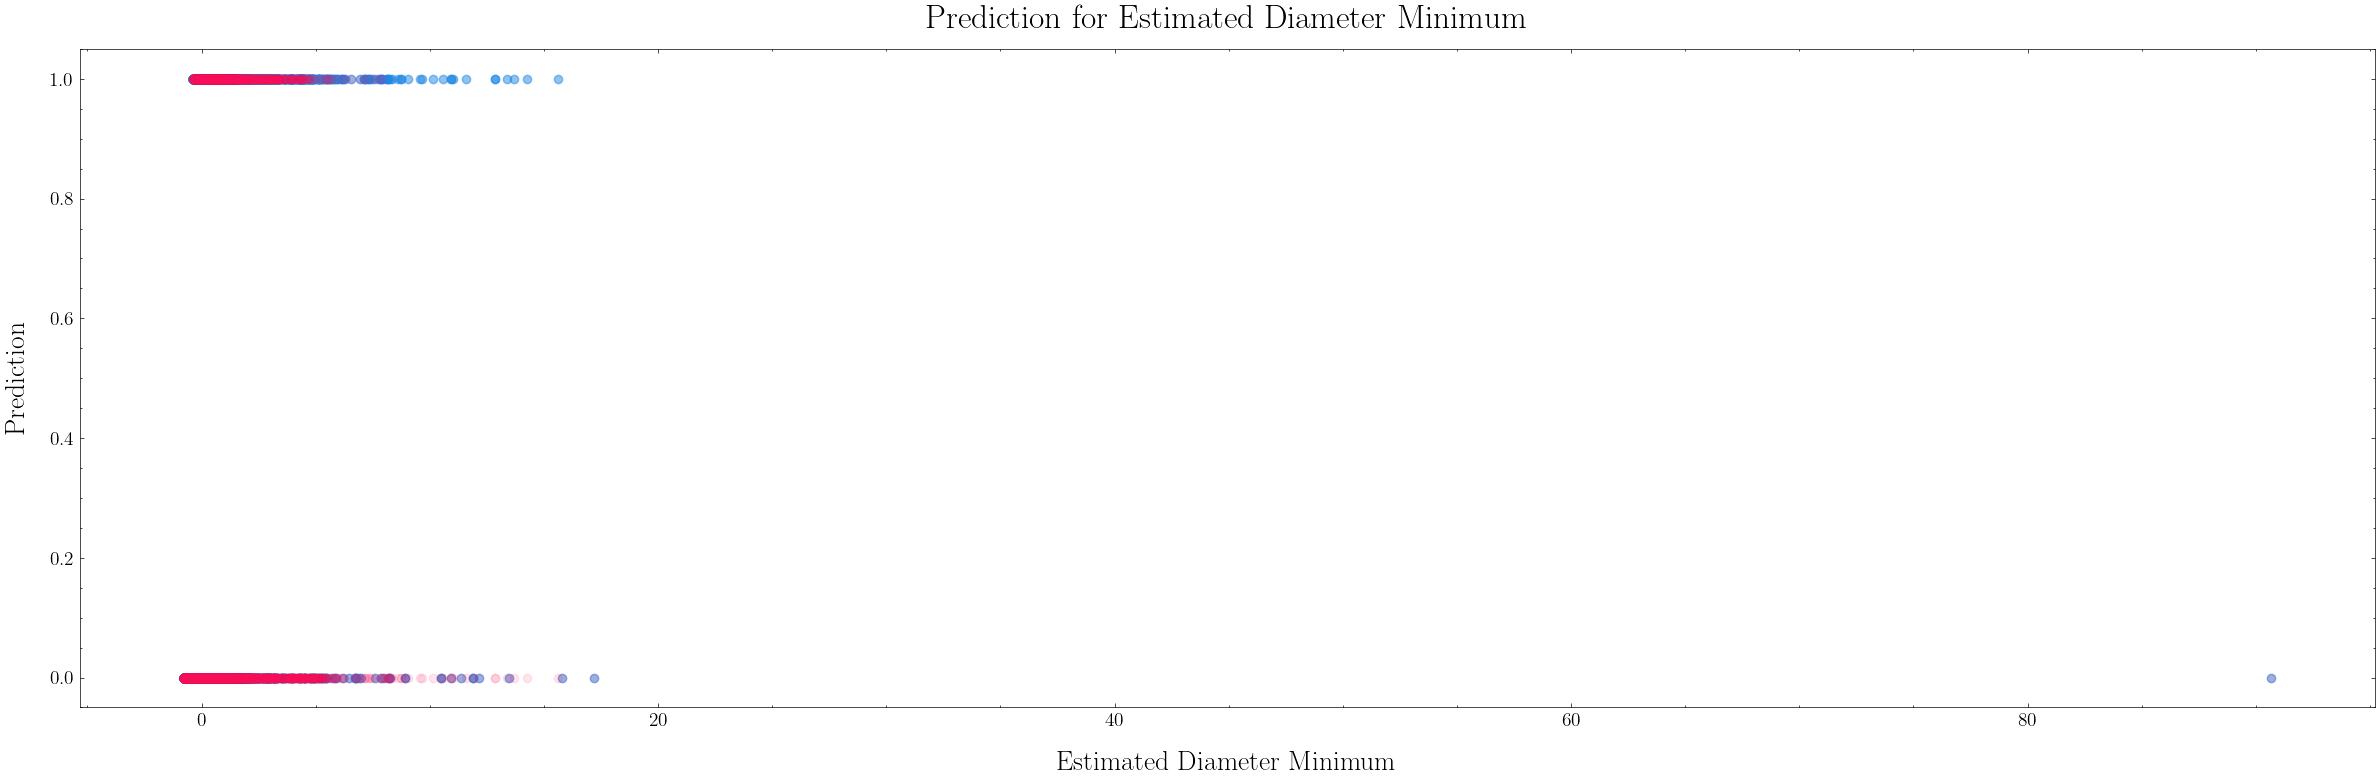

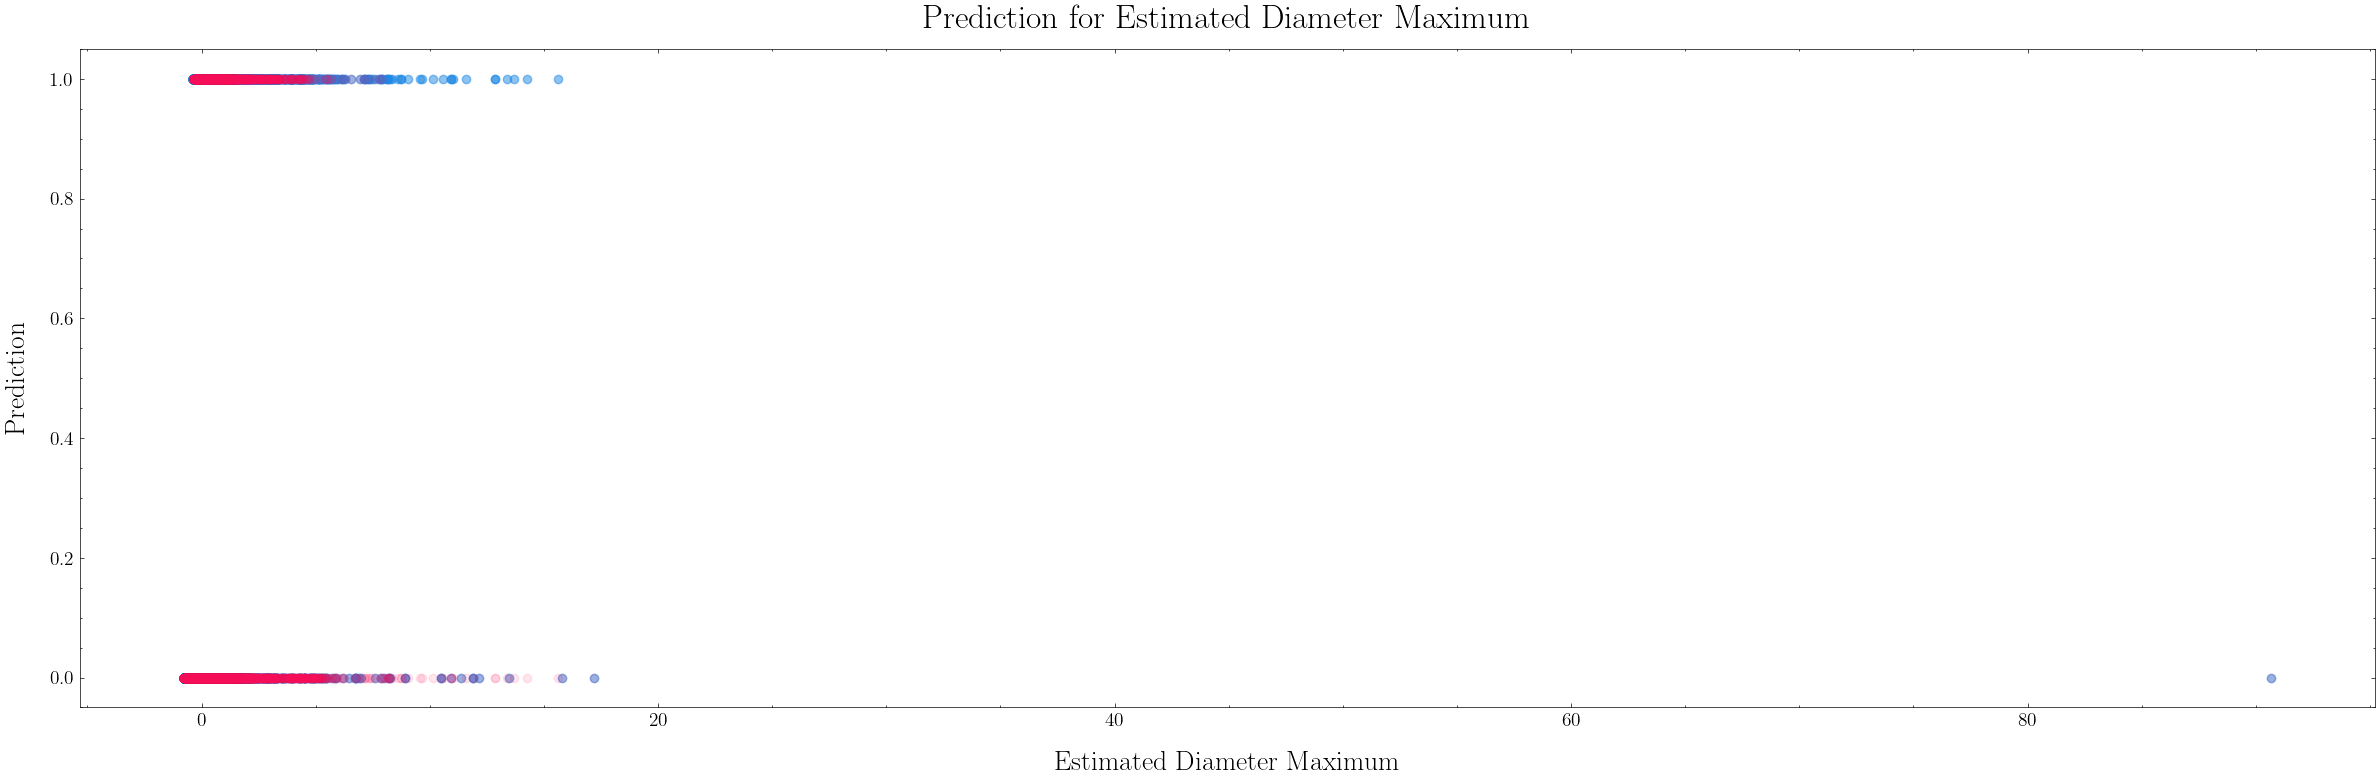

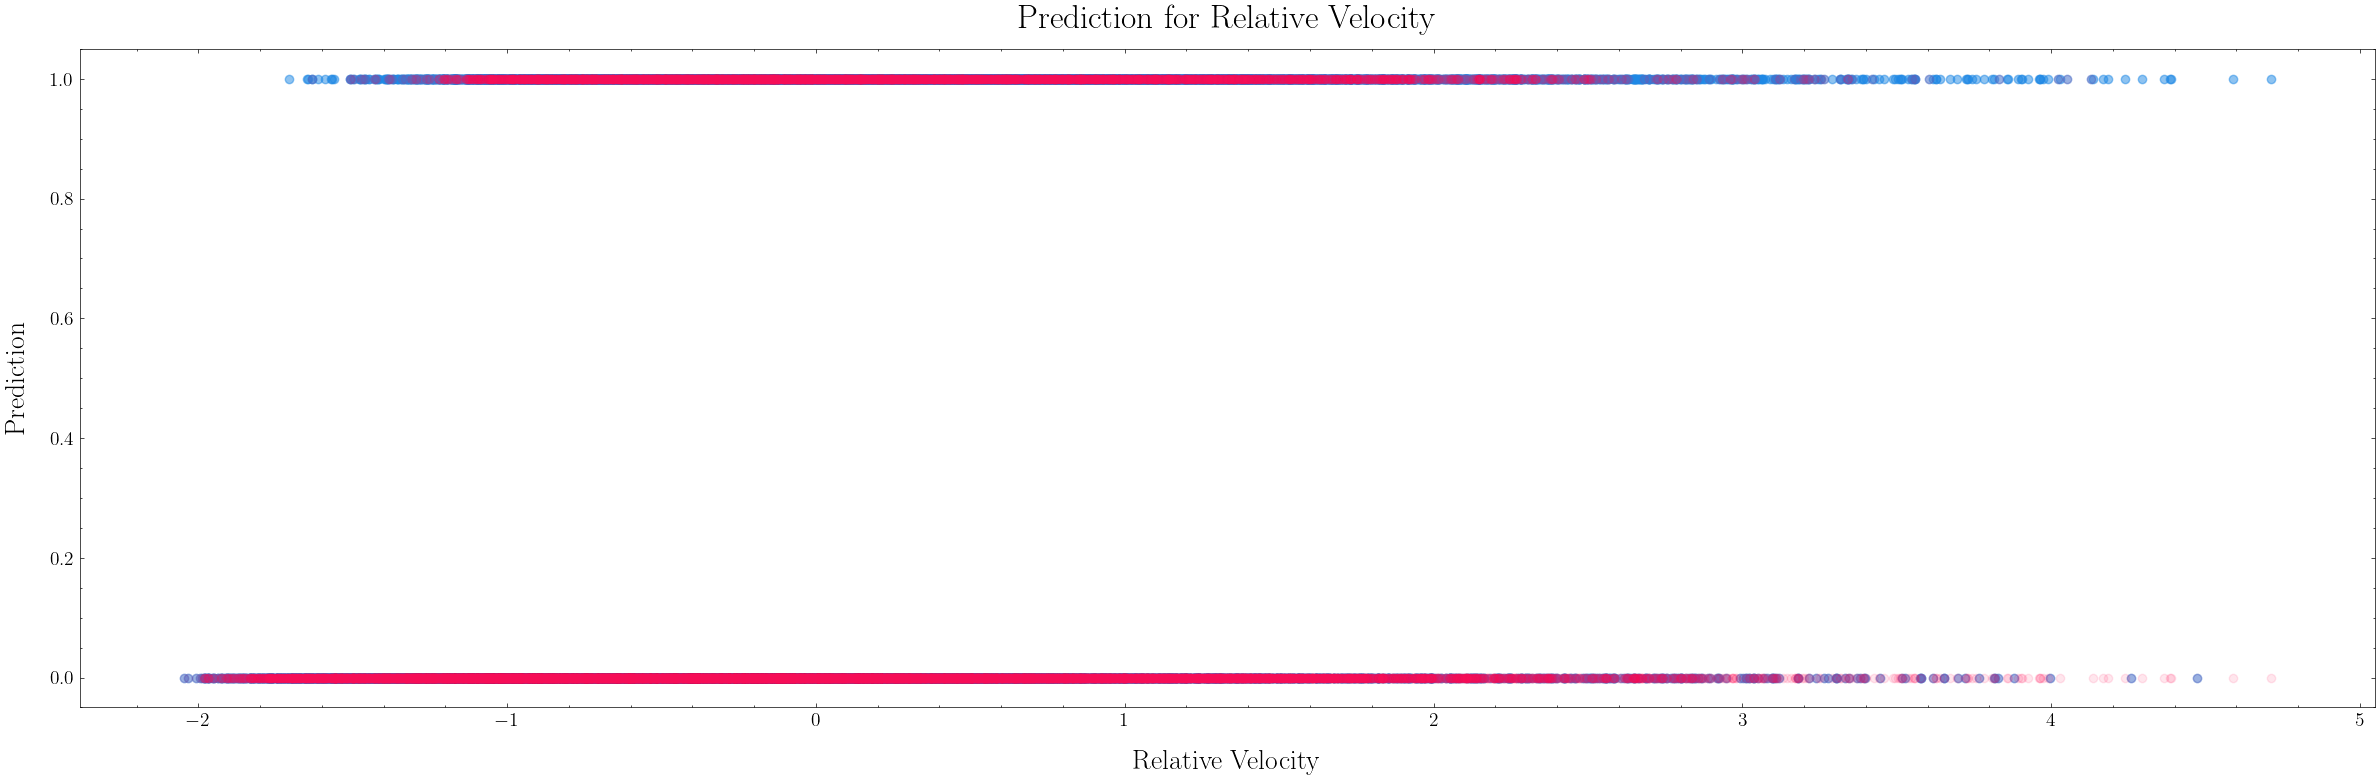

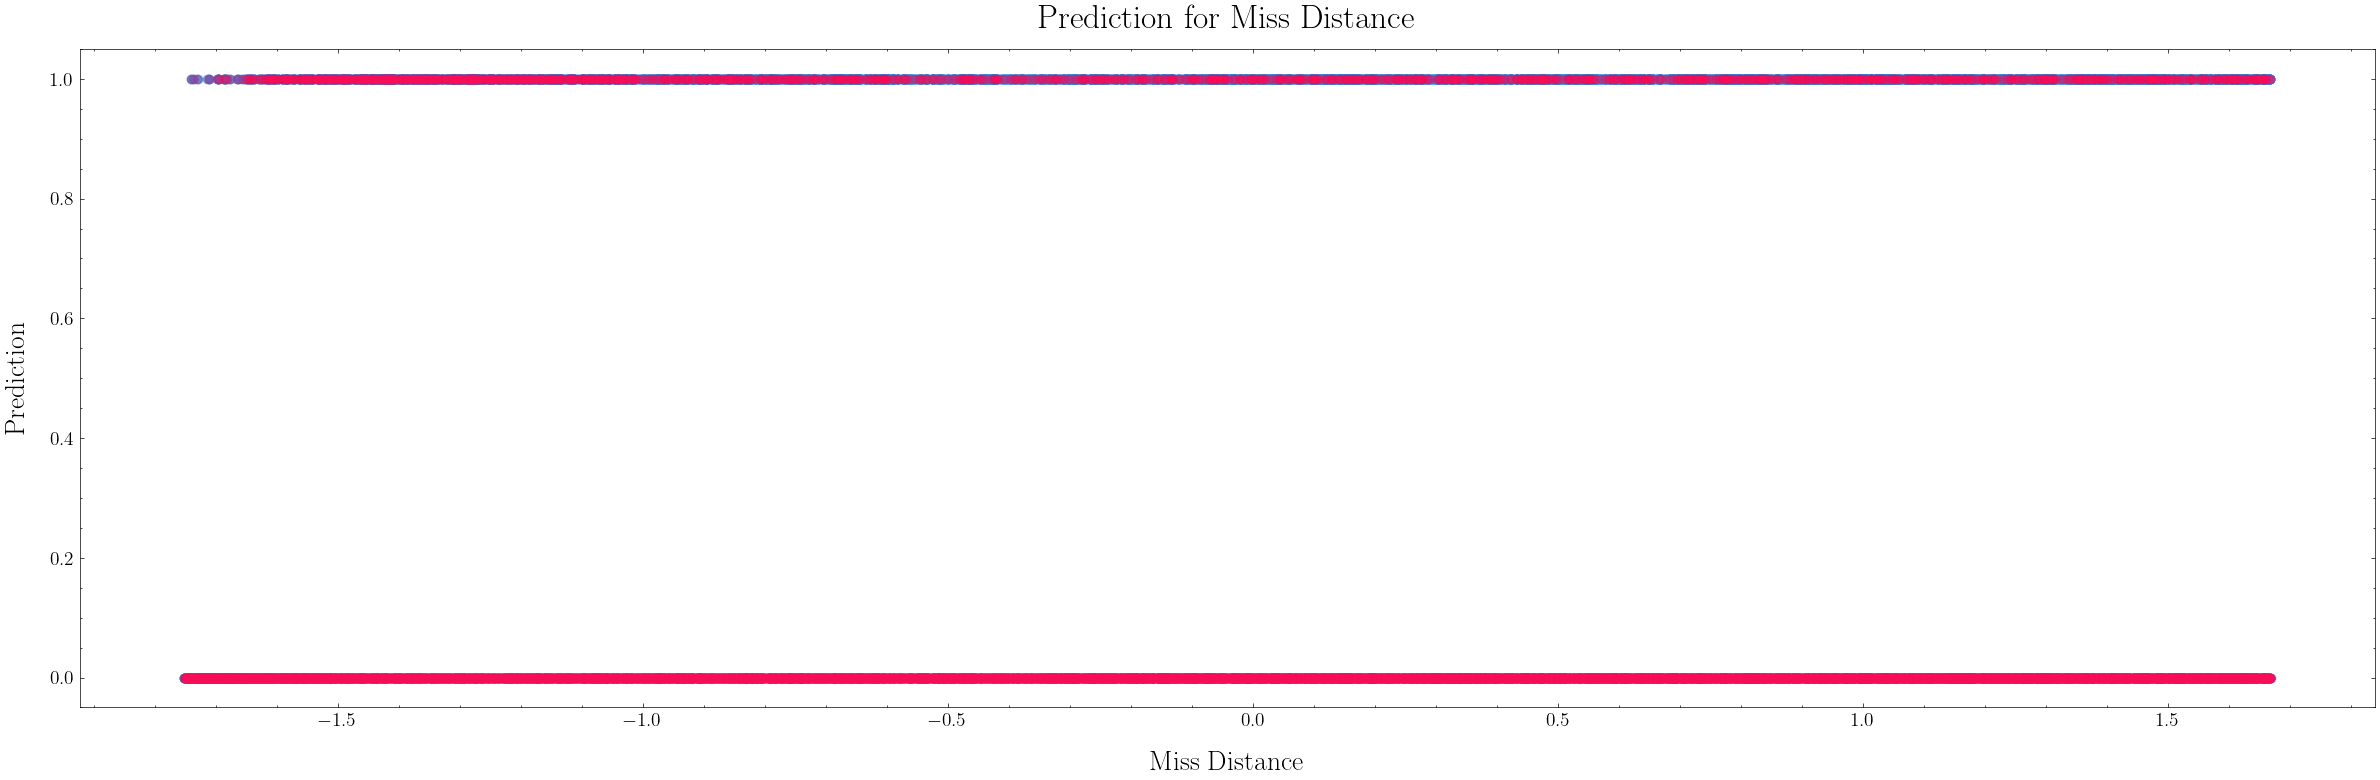

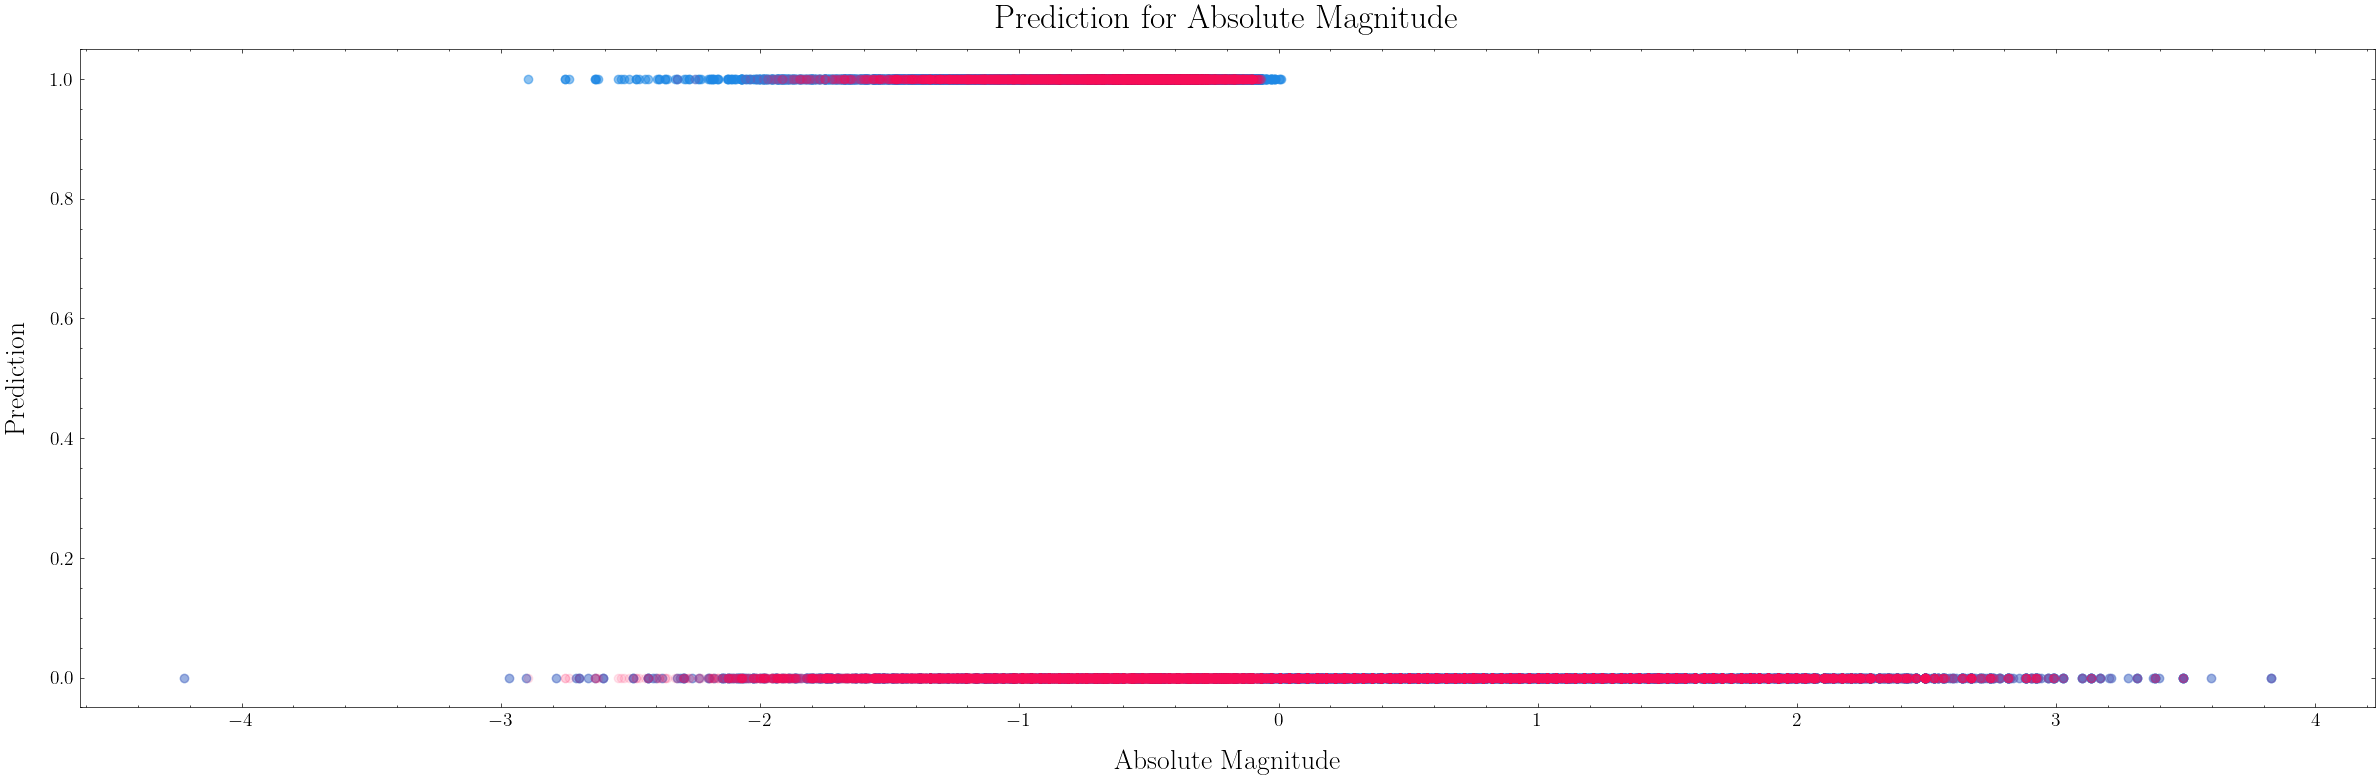

In [56]:
for column in numerical.columns:
    figsize = (24, 8)
    fig, ax = plt.subplots(figsize=figsize)

    ax.scatter(
        x=X_test[column],
        y=y_test,
        color='#1e88e5',
        alpha=0.50
    )

    ax.scatter(
        x=X_test[column],
        y=y_pred_threshold,
        color='#ff0d57',
        alpha=0.10
    )

    column = column_to_title(column)

    ax.set_ylabel('Prediction')
    ax.set_xlabel(column)

    ax.set_title(f"Prediction for {column}")
    
    plt.tight_layout()
    plt.show()
    
    print('\n \n')

plt.close('all')

At a `0.90` threshold, there is small variance between predicted vs. observed. However, the model still struggled to identify if an asteroid was hazardous on the extreme end (low and high) of each variable.

$$ \text{\Large{SHAP}} $$

In [57]:
%%capture

train = shap.sample(X_train, 500)
test = shap.sample(X_test, 500)

explainer = shap.KernelExplainer(model_deep, train)
shap_values = explainer.shap_values(test)

features = X_test.columns

We used a subsample of our dataset due to the sheer size of the original dataset.

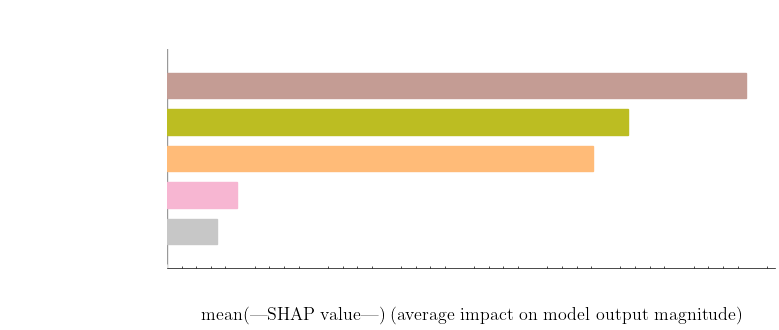

In [58]:
palette = plt.get_cmap('tab20').colors 

figsize = (24, 8)
plt.figure(figsize=figsize)

shap.summary_plot(
    shap_values[:, :, 0],
    test,
    feature_names=features,
    plot_type='bar',
    show=False
)

ax = plt.gca()

length = len(ax.patches)
colors = sample(palette, length)

for patch, color in zip(ax.patches, colors):
    patch.set_color(color)

labels = [label.get_text().title() for label in ax.get_yticklabels()]
ax.set_yticklabels(labels)

ax.tick_params(axis='x', colors='white')
ax.tick_params(axis='y', colors='white')
plt.title('Summary Plot: Feature Importance', color='white')

plt.tight_layout()

file = path.joinpath('sp2.png')
plt.savefig(file, format='png')

plt.show()
# plt.close()

The feature importance in our shallow learning model is also reflected in the deep learning model. The deep learning model seemed to rely on *Absolute Magnitude* to make predictions, while variables such as *Relative Velocity* and *Miss Distance* hardly affect the outcome.

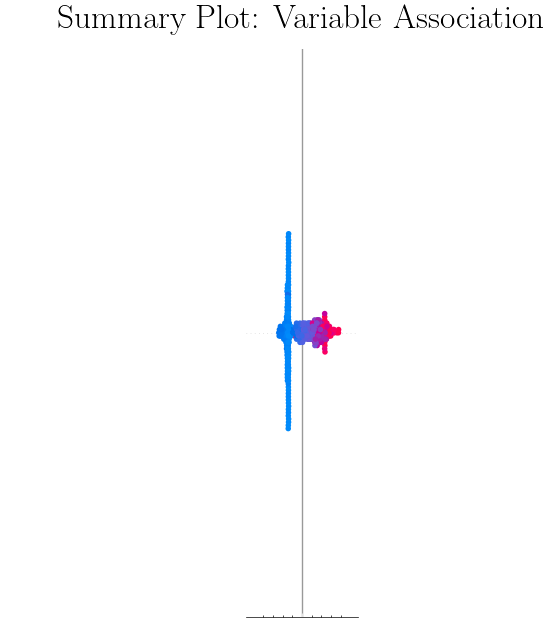

In [59]:
plot_size = (24, 8)

shap.summary_plot(
    shap_values,
    test,
    feature_names=features,
    plot_size=plot_size,
    show=False,
    title='Summary Plot'
)

ax = plt.gca()

labels = [
    column_to_title(
        label.get_text()
    )
    for label in ax.get_yticklabels()
]

ax.set_yticklabels(labels)

ax.tick_params(axis='x', colors='white')
ax.tick_params(axis='y', colors='white')

ax.set_title('Summary Plot: Variable Association')

plt.tight_layout()

file = path.joinpath('sp2.png')
plt.savefig(file, format='png')

plt.show()
plt.close()

$$ \text{\Large{Generalization/Interpretation}} $$

**Color**
- **<font color=#ff0d57>Red</font>:** High
- **<font color=#1e88e5>Blue</font>:** Low

<br>

**Absolute Magnitude**
- The lower the absolute magnitude, the higher the shap value.
    - A low(er) absolute magnitude will result in the model predicting an asteroid as hazardous.
- The higher the absolute magnitude, the lower the shap value.
    - A high(er) absolute magnitude will result in the model predicting an asteroid as **not** hazardous.

<br>

**Estimated Diameter Minimum**
- The lower the estimated diameter minimum, the lower the shap value.
    - A low(er) estimated diameter minimum will result in the model predicting an asteroid as **not** hazardous.
- The higher the estimated diameter minimum, the higher the shap value.
    - A high(er) estimated diameter minimum will result in the model predicting an asteroid as hazardous.

<br>

**Estimated Diameter Maximum**
- The lower the estimated diameter maximum, the higher the shap value.
    - A lower(er) estimated diameter maximum will result in the model predicting an asteroid as **not** hazardous.
- The higher the estimated diameter maximum, the lower the shap value.
    - A high(er) estimated diameter maximum will result in the model predicting an asteroid as hazardous.

<br>

**Relative Velocity**
- The lower the relative velocity, the lower the shap value.
    - A low(er) relative velocity will result in the model predicting an asteroid as **not** hazardous.
- The higher the relative velocity, the higher the shap value.
    - A high(er) relative velocity will result in the model predicting an asteroid as hazardous.

<br>

**Miss Distance**
- The lower the miss distance, the higher the shap value.
    - A low(er) miss distance will result in the model predicting an asteroid as hazardous.
- The higher the miss distance, the lower the shap value.
    - A high(er) miss distance will result in the model predicting an asteroid as **not** hazardous.

In [60]:
shap.initjs()

row = 10
shap_values = shap_values[:, :, 0]
feature_names = test.columns.tolist()

shap.force_plot(
    explainer.expected_value[0],
    shap_values[row],
    test.iloc[[row]],
    feature_names=feature_names,
    link='logit'  
)

$$\text{\Huge{Discussion}}$$

Our deep learning model consistently outperformed the shallow learning model. Our target variable: *hazardous* was severely imbalanced (**False:** 81996, **True:** 8840). If we used the imbalanced version of our dataset to train each model, then we observed a minimal gain of accuracy (1-2%) from our deep learning model. The shallow learning model obtained a constant 90% accuracy, and the deep learning model hovered around 91%. However, after resampling our dataset using [SMOTE](https://imbalanced-learn.org/stable/references/generated/imblearn.over_sampling.SMOTE.html) to be ~ 50/50 (False/True), we saw a noticeable gain in accuracy from the shallow to deep learning model. The shallow learning model's predictive accuracy ranged from 82-85% and the deep learning model's predictive accuracy ranged from 87-89%. After running each model numerous times and increasing/decreasing the hyperparameter search space, the deep learning model **always** outperformed the shallow learning model.

**Angela:** I think that the extra explainability of a simple model is more important because it was much simpler to grasp how our logisitic regression model functions and to identify problems. It was more challenging to comprehend what was happening with the neural network model, and troubleshooting was exceedingly tough when something went wrong.

**Brayden:** In a toy example such as this, the explainability is useful for educational purposes. If we are able to grasp the simple model, then it might offer intuition about a more complicated model. However, in the real world, I would prefer a complicated model and good predictive accuracy over a simple model that could be explained. If the model could predict and help prevent a dangerous scenario, then the explainability is less important to me (as long as it is truly accurate). In the event that the accuracy is relatively close between a simple vs. complex model, as is in our case, then the simple model would be preferable, as we may glean insight into *why* and *how* the model is making these predictions.